In [132]:
#@title ##### License
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Dynamics of a HALE aircraft in GUST

input file: HALE_light_simulations_reduced_loads.pickle
Wing only

Code with custom linear Block for globals


# Code

In [133]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf
from tensorflow.python.framework import ops

import time
import imp
from matplotlib.pyplot import imshow

from matplotlib import pyplot as plt
import numpy as np
import pickle
import sys
import os
# insert at 1, 0 is the script path (or '' in REPL)

#locally modified modules
sys.path.insert(1, os.getcwd())
import modules
import models
import blocks
import random

try:
  import seaborn as sns
except ImportError:
  pass
else:
  sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)
%matplotlib inline

In [134]:
#directory='/home/dmsm/m.colombo/Documents/cases/data/HALE_50_2st2m_L/'
#filename_tr='HALE_50_2st2m_Lc_loads_tr.pickle'
#filename_va='HALE_50_2st2m_Lc_loads_va.pickle'

directory='/home/dmsm/m.colombo/Documents/sharpy/data/'
filename_tr='HALE_50_2st2m_unitloads_tr.pickle'
filename_va='HALE_50_2st2m_unitloads_va.pickle'

In [135]:
#@title Helper functions  { form-width: "30%" }

 
def normalize_el(el,var,mean):    
    #normalization of nodes and edges
    
    el= tf.math.divide(tf.math.subtract(el,mean),var)
    
    return el          

def denormalize_el(el,var,mean):    
    #normalization of nodes and edges
    
    el= tf.math.add(tf.math.multiply(el,var),mean)
    
    return el    


def normalize_graph(graph,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals):
    graph=graph.replace(nodes=normalize_el(graph.nodes,var_nodes,mean_nodes))
    graph=graph.replace(edges=normalize_el(graph.edges,var_edges,mean_edges))
    graph=graph.replace(globals=normalize_el(graph.globals,var_globals,mean_globals))
    
    return graph

def noise_graph(graph,stddev=0.0001):
    graph=graph.replace(nodes=graph.nodes+tf.random.normal(graph.nodes.shape,mean=0.0,stddev=stddev,dtype=graph.nodes.dtype))
    graph=graph.replace(edges=graph.edges+tf.random.normal(graph.edges.shape,mean=0.0,stddev=stddev,dtype=graph.nodes.dtype))
    graph=graph.replace(globals=graph.globals+tf.random.normal(graph.globals.shape,mean=0.0,stddev=stddev,dtype=graph.nodes.dtype))
    
    return graph

def denormalize_graph(graph,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals):
    graph=graph.replace(nodes=denormalize_el(graph.nodes,var_nodes,mean_nodes))
    graph=graph.replace(edges=denormalize_el(graph.edges,var_edges,mean_edges))
    graph=graph.replace(globals=denormalize_el(graph.globals,var_globals,mean_globals))
    
    return graph

def normalize_globals_graph(graph,var_globals,mean_globals):
    graph=graph.replace(globals=normalize_el(graph.globals,var_globals,mean_globals))
    
    return graph

def denormalize_globals_graph(graph,var_globals,mean_globals):
    graph=graph.replace(globals=denormalize_el(graph.globals,var_globals,mean_globals))
    
    return graph

def create_graphs(trainf=0.8,delta_shift=1):
    
    #read pickles with packed data
    nodes_tr,    edges_in_tr,    edges_tar_tr,    globals_tr,    senders,    receivers, list_tse_raw    = pickle.load(open(directory+filename_tr, "rb"))
    nodes_va,    edges_in_va,    edges_tar_va,    globals_va,    senders,    receivers, list_tse_raw    = pickle.load(open(directory+filename_va, "rb"))
    

    #stock data i graph_in /graph out structure
    #in: nodes t, global t, edges_in (structural)
    #out: nodes t+1, global t+1, edges_tar t (loads)
    #ltlsteps is taken as input , it is the maximum length of time sequence for the long term loss    
    graph_in_tr=list()
    graph_tar_tr=list()
    
    idx_globals_in=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #longitudinal displacements , speeds + external input (wind)
    idx_globals_out=[10, 12, 14, 16, 18] #longitudinal displacements , speeds 
    idx_globals_out_ltl=[10, 12, 14, 16, 18, 20] #rates + external input (wind)
    idx_nodes_in=[1,5,7,11,13,15] #y0 position (wing) = 1 ; dz|ry = (2,4) + 3 (from first coordinate );  dz|dry / dt = (2,4) + 9 ,lumped mass
    idx_nodes_out=[11,13] #y0 position (wing) = 1 ; dz|ry = (2,4) + 3 (from first coordinate );  dz|dry / dt = (2,4) + 9 ,lumped mass
    idx_edgesin=[0,2]   #stiffness /mass info
    idx_edgesout=[2,3,4] #tz mx My
         
    
            
    for t in range(nodes_tr.shape[2]-(ltlsteps)*delta_shift):
          graph_in_tr.append({   "globals": np.squeeze(globals_tr[idx_globals_in,t]),
                                  "nodes": np.squeeze(nodes_tr[:,idx_nodes_in,t]),
                                  "edges": np.squeeze(edges_in_tr[:,idx_edgesin,t]),
                                  "receivers": list(receivers),
                                  "senders": list(senders)
                             })
          graph_tar_tr.append({   "globals": np.squeeze(globals_tr[idx_globals_out,t+delta_shift]),
                                  "nodes": np.squeeze(nodes_tr[:,idx_nodes_out,t+delta_shift]),
                                  "edges": np.squeeze(edges_tar_tr[:,idx_edgesout,t]),
                                  "receivers": list(receivers),
                                  "senders": list(senders)
                              }) 
    #graph_ltl is the list to stock graphs used for long term loss
    graph_ltl_tr=list()   
    
    #tt ranges from 1 as the first step of the long term loss uses merges info from graph_tar (t+1)         
    for tt in range(1,ltlsteps+1):
        graph_ltl_tt_tr=list() 
        for t in range(nodes_tr.shape[2]-ltlsteps*delta_shift):      
            graph_ltl_tt_tr.append({"globals": np.squeeze(globals_tr[idx_globals_out_ltl,t+tt*delta_shift]),              
                                       "nodes": np.squeeze(nodes_tr[:,idx_nodes_out,t+tt*delta_shift]),
                                       "edges": np.squeeze(edges_tar_tr[:,idx_edgesout,t+(tt-1)*delta_shift]),
                                       "receivers": list(receivers),
                                       "senders": list(senders)
                                        })       
        graph_ltl_tr.append(graph_ltl_tt_tr) 

        
    #validation graphs        
    graph_in_va=list()
    graph_tar_va=list()
    for t in range(nodes_va.shape[2]-(ltlsteps)*delta_shift):
          graph_in_va.append({   "globals": np.squeeze(globals_va[idx_globals_in,t]),
                                  "nodes": np.squeeze(nodes_va[:,idx_nodes_in,t]),
                                  "edges": np.squeeze(edges_in_va[:,idx_edgesin,t]),
                                  "receivers": list(receivers),
                                  "senders": list(senders)
                             })
        
        
          graph_tar_va.append({   "globals": np.squeeze(globals_va[idx_globals_out,t+delta_shift]),
                                  "nodes": np.squeeze(nodes_va[:,idx_nodes_out,t+delta_shift]),
                                  "edges": np.squeeze(edges_tar_va[:,idx_edgesout,t]),
                                  "receivers": list(receivers),
                                  "senders": list(senders)
                              }) 
            

    
    
    return graph_in_tr,graph_tar_tr,graph_ltl_tr,graph_in_va,graph_tar_va

def create_loss_all(target_op, output_op):
  """
   normal loss function:
   all nodes but  x0 y0 z0 coordinates,
   all edges,  
   all globals but last input that is wind
  """
  
  loss = [tf.reduce_mean((output_op.nodes - target_op.nodes )**2)
           +tf.reduce_mean((output_op.edges - target_op.edges)**2) 
           +tf.reduce_mean((output_op.globals - target_op.globals)**2)]
  
  return tf.stack(loss)


def create_loss_ltl(output_op, target_op, output_op_ltl, target_ltl, beta=0.05):
  """
  long term loss function:  
  first term: normal loss function:
   all nodes but  x0 y0 z0 coordinates,
   all edges,  
   all globals but last input that is wind
   second term : beta* output long term loss - target long term loss
   all nodes but  x0 y0 z0 coordinates,
   all edges,  
   all globals but last input that is wind
   
  """

  #the index 1 on nodes is to avoid including the x0 in loss 
  
  loss = [tf.reduce_mean((output_op.nodes - target_op.nodes)**2)
           +tf.reduce_mean((output_op.edges - target_op.edges)**2) 
           +tf.reduce_mean((output_op.globals - target_op.globals)**2)
           + beta * tf.reduce_mean((output_op_ltl.nodes - target_ltl.nodes)**2)
           + beta * tf.reduce_mean((output_op_ltl.edges - target_ltl.edges)**2) 
           + beta * tf.reduce_mean((output_op_ltl.globals - target_ltl.globals[:,0:-1])**2)]
  return tf.stack(loss)




def make_all_runnable_in_session(*args):
  """Apply make_runnable_in_session to an iterable of graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]





def count_params(model):
    total_parameters = 0
    for var in model.trainable_variables:
        # shape is an array of tf.Dimension
        shape = var.shape
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim
        #print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)
    


In [136]:

# Data / training parameters.
num_training_iterations = 1000
ltlsteps=10
delta_shift=6
dt=0.0125*delta_shift
#create training graphs
graph_in_tr,graph_tar_tr, graph_ltl_tr,graph_in_va, graph_tar_va = create_graphs(trainf=0.8,delta_shift=delta_shift)
  
#tfgraphs_in_tr = utils_tf.data_dicts_to_graphs_tuple(graph_in_tr)
#tfgraphs_tar_tr = utils_tf.data_dicts_to_graphs_tuple(graph_tar_tr)



In [137]:


orderlist = list(range(len(graph_in_tr)))
all_list = list(zip(graph_in_tr,graph_tar_tr,orderlist))
random.shuffle(all_list)

graph_in_tr_sh,graph_tar_tr_sh,orderlist = zip(*all_list)

#shuffled training data to use correctly mini batches
tfgraphs_in_tr = utils_tf.data_dicts_to_graphs_tuple(graph_in_tr_sh)
tfgraphs_tar_tr = utils_tf.data_dicts_to_graphs_tuple(graph_tar_tr_sh)

#shuffle long term loss data with same order
tfgraphs_ltl_tr=list()
for el in graph_ltl_tr:
    newlist = [el[i] for i in orderlist]    
    tfgraphs_ltl_tr.append(utils_tf.data_dicts_to_graphs_tuple(newlist))

#not shuffled data for any usage
tfgraphs_in_tr_nsh = utils_tf.data_dicts_to_graphs_tuple(graph_in_tr)
tfgraphs_tar_tr_nsh = utils_tf.data_dicts_to_graphs_tuple(graph_tar_tr)

#create list of not shuffled tf graphs 
tfgraphs_ltl_tr_nsh=list()
for el in graph_ltl_tr:
    tfgraphs_ltl_tr_nsh.append(utils_tf.data_dicts_to_graphs_tuple(el))



In [138]:
#get all nodes from all trajectories to calculate a proper mean/variance 
vnodesin=graph_in_tr[0]['nodes']
vnodesout=graph_tar_tr[0]['nodes']
vedgesin=graph_in_tr[0]['edges']
vedgesout=graph_tar_tr[0]['edges']
globsin=np.expand_dims(graph_in_tr[0]['globals'],axis=0)
globsout=np.expand_dims(graph_tar_tr[0]['globals'],axis=0)
for i in range(1,len(graph_in_tr)):
    vnodesin=tf.concat([vnodesin, graph_in_tr[i]['nodes']],axis=0)
    vnodesout=tf.concat([vnodesout, graph_tar_tr[i]['nodes']],axis=0)
    vedgesin=tf.concat([vedgesin, graph_in_tr[i]['edges']],axis=0)
    vedgesout=tf.concat([vedgesout, graph_tar_tr[i]['edges']],axis=0)
    globsin=tf.concat([globsin, np.expand_dims(graph_in_tr[i]['globals'],axis=0)],axis=0)
    globsout=tf.concat([globsout, np.expand_dims(graph_tar_tr[i]['globals'],axis=0)],axis=0)
    
var_nodesin= 2*np.sqrt(np.var(vnodesin,axis=0))
var_nodesout= 2*np.sqrt(np.var(vnodesout,axis=0))
var_edgesin= 2*np.sqrt(np.var(vedgesin,axis=0))
var_edgesout= 2*np.sqrt(np.var(vedgesout,axis=0))

var_globalsin= 2*np.sqrt(np.var(globsin,axis=0))
var_globalsout= 2*np.sqrt(np.var(globsout,axis=0))

mean_nodesin= np.mean(vnodesin,axis=0)
mean_nodesout= np.mean(vnodesout,axis=0)
mean_edgesin= np.mean(vedgesin,axis=0)
mean_edgesout= np.mean(vedgesout,axis=0)
mean_globalsin= np.mean(globsin,axis=0)
mean_globalsout= np.mean(globsout,axis=0)

#to preserve derivatives
var_nodesin[2:4]=var_nodesin[0:2]
var_nodesout=var_nodesin[0:2]
var_globalsin[5:10]=var_globalsin[0:5]
var_globalsout=var_globalsin[0:5]
var_globalsoutltl= np.hstack([var_globalsout,var_globalsin[-1]])

mean_nodesin[2:4]=0
mean_nodesout=mean_nodesout*0
mean_globalsin[5:10]=0
mean_globalsout=mean_globalsout*0
mean_globalsoutltl= np.hstack([mean_globalsout,mean_globalsin[-1]])

#lumped mass adjustment to normalize to 0/1
var_nodesin[-1]=np.max(np.abs(vnodesin[:,-1]))
mean_nodesin[-1]=0


In [139]:

#if taking only the wing some variables have zero variability
#var_edgesin=np.ones(var_edgesin.shape)
print('variances')

print(var_nodesin)
print(var_edgesin)
print(var_globalsin)
print(var_nodesin)
print(var_edgesout)
print(var_globalsout)

print('means')

print(mean_nodesin)
print(mean_edgesin)
print(mean_globalsin)
print(mean_nodesin)
print(mean_edgesout)
print(mean_globalsout)

#plt.plot(np.diff(globsin[0:100:,4]/0.0125))
#plt.plot(globsin[0:100,9])


variances
[ 9.27585267  0.91377189  9.27585267  0.91377189  0.58400145 50.        ]
[3.51604747e-01 5.36345841e+06]
[54.38539048  8.10131915  0.51127656  4.43542291  0.39102276 54.38539048
  8.10131915  0.51127656  4.43542291  0.39102276  5.62921574]
[ 9.27585267  0.91377189  9.27585267  0.91377189  0.58400145 50.        ]
[ 15.95424934  66.20923599 288.79024013]
[54.38539048  8.10131915  0.51127656  4.43542291  0.39102276]
means
[ 7.48487211e+00  2.74845067e-01  0.00000000e+00  0.00000000e+00
 -5.08180695e-03  0.00000000e+00]
[8.24812318e-01 1.12205170e+07]
[-3.90785830e+01  5.02028199e+00  2.41600831e-02  3.20928442e+00
  2.85534613e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.19672814e+00]
[ 7.48487211e+00  2.74845067e-01  0.00000000e+00  0.00000000e+00
 -5.08180695e-03  0.00000000e+00]
[  0.92163757  -0.68711494 -28.10799038]
[-0.  0. -0.  0.  0.]


In [140]:
#normalization and noising graphs : training   
tfgraphs_in_tr_norm=normalize_graph(tfgraphs_in_tr,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
tfgraphs_in_tr_norm_noised=noise_graph(tfgraphs_in_tr_norm,stddev=0.001)
tfgraphs_tar_tr_norm=normalize_graph(tfgraphs_tar_tr,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)
tfgraphs_tar_tr_norm_noised=noise_graph(tfgraphs_tar_tr_norm,stddev=0.001)

tfgraphs_ltl_norm=list()
for gr in tfgraphs_ltl_tr:
    tfgraphs_ltl_norm.append(normalize_graph(gr,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsoutltl,mean_globalsoutltl))

#validation
tfgraphs_in_va = utils_tf.data_dicts_to_graphs_tuple(graph_in_va)
tfgraphs_tar_va = utils_tf.data_dicts_to_graphs_tuple(graph_tar_va)

tfgraphs_in_va_norm=normalize_graph(tfgraphs_in_va,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
tfgraphs_tar_va_norm=normalize_graph(tfgraphs_tar_va,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)

#not shuffled data for training
tfgraphs_in_tr_nsh_norm=normalize_graph(tfgraphs_in_tr_nsh,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
tfgraphs_tar_tr_nsh_norm=normalize_graph(tfgraphs_tar_tr_nsh,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)

tfgraphs_ltl_norm_nsh=list()
for gr in tfgraphs_ltl_tr_nsh:
    tfgraphs_ltl_norm_nsh.append(normalize_graph(gr,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsoutltl,mean_globalsoutltl))

#input_va=noise_graph(input_va,stddev=0.001)
#target_va=noise_graph(target_va,stddev=0.001)






In [141]:




#@title Set up model training and evaluation  { form-width: "30%" }
ops.reset_default_graph()

imp.reload(modules)
imp.reload(blocks)
imp.reload(models)

# Create the model.

nodetoglobal_size=2  #number of extra globals. (theoretically for an aeroelastic aircraft this could be the number of elastic modes)
edgetoglobal_size=4 #number of inputs to globals from edges (theoretically for a symmetrical aircraft I would think of Lift and pitching moment + a force per extra mode)

bfull=0
bnorm=1
model = models.SimpleEncodeProcessDecode(num_units=256,
                       num_layers=2,
                       edge_core_size=var_edgesout.shape[0],
                       node_core_size=var_nodesout.shape[0],
                       global_core_size=var_globalsout.shape[0],
                       edge_output_size=None,
                       node_output_size=None,
                       global_output_size=None,
                       edgetoglobal_size=edgetoglobal_size,
                       nodetoglobal_size=nodetoglobal_size
                      )

model._core._network._node_block._use_sent_edges=True
model._core._network._node_block._sent_edges_aggregator = blocks.SentEdgesToNodesAggregator(tf.math.unsorted_segment_sum)


In [142]:
batch_size=1024
num_graphs = utils_tf.get_num_graphs(tfgraphs_in_tr_norm_noised)
    

def roll_out_ltl(tfgraph_in_ro,tfgraph_ltl_ro,len_roll,dt=0.0125):
        
    
    tfgraph_step_norm=tfgraph_in_ro
    #tfgraph_cur_step_norm=tfgraph_step_norm.copy()
    

    for t_ltl in range(len_roll):
        
        

        #edges in are not loads, just structural values, they don't change
        tfgraph_step_norm=tfgraph_step_norm.replace(edges=tfgraph_in_ro.edges)
        
        tfgraph_cur_step_norm=model(tfgraph_step_norm,1)     #1st loop : uses input graph t . 
        #ltl graphs first entry is t+tt*delta_shift with tt=1. ==> t+1*ds, t+2*ds,  
        #the output of model is t+ds . so for example
        #ltl_steps=3  model==> t+ds , new input: wind at t+ds , model==> t+2ds , new input : wind at t+2ds ,model==> t+3ds ==> break. loss computation against graph_ltl @ t+3ds
        

        nodes_int=tfgraph_step_norm[0][:,1:3]*dt+tfgraph_step_norm[0][:,3:5]        
        globs_int=tfgraph_step_norm[4][:,5:10]*dt+tfgraph_step_norm[4][:,0:5]        
        
                                      
        #t=0 corresponds to a long term loss graph which is one time step ahead.
        # last global column is the input
        tfgraph_step_norm=tfgraph_step_norm.replace(globals=tf.concat([globs_int,tfgraph_cur_step_norm[4],tf.expand_dims(tfgraph_ltl_ro[t_ltl].globals[:,-1],1)],axis=1),
                                                    nodes=tf.concat([tf.expand_dims(tfgraph_in_ro.nodes[:,0],1),nodes_int,tfgraph_cur_step_norm[0],tf.expand_dims(tfgraph_in_ro.nodes[:,-1],1)],axis=1))
        

    return tfgraph_cur_step_norm




# Training of reference model
def update_step_ref(gr_in, gr_tar,gr_ltl_tar,beta,len_roll,dt=0.0125):
  with tf.GradientTape() as tape:
    gr_out=model(gr_in,1)
    gr_ltl=roll_out_ltl(gr_in,gr_ltl_tar,len_roll=len_roll,dt=dt)
    # Loss.
    loss_tr = create_loss_ltl(gr_out, gr_tar,gr_ltl, gr_ltl_tar[len_roll-1],beta=beta )  #-1 to idnex last 
    
 
    
    
  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return loss_tr


def update_step_ref_noltl(gr_in, gr_tar):
  with tf.GradientTape() as tape:
    gr_out=model(gr_in,1)    
    # Loss.
    loss_tr = create_loss_all(gr_tar, gr_out)
    
  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return loss_tr


# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)
# How much time between logging and printing the current results.
log_every_seconds = 10


last_iteration = 0
start_time = time.time()
last_log_time = start_time
loss_tr_hist=list()
loss_tr_noltl_hist=list()
loss_va_hist=list()
iteration_hist=list()

for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  #t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
  for step in range(0,int(num_graphs/batch_size),batch_size): 
      
      #progressively more greedy on long term loss
      beta=0.05
      #progressively longer long term loss
      #len_roll=1+int(ltlsteps*iteration/(num_training_iterations+1))
      len_roll=ltlsteps
        

      loss_tr_ref = update_step_ref(utils_tf.get_graph(tfgraphs_in_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)),
                                    utils_tf.get_graph(tfgraphs_tar_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)),
                                    list(utils_tf.get_graph(el,slice(step*batch_size,(step+1)*batch_size)) for el in tfgraphs_ltl_norm),
                                    beta=beta,
                                    len_roll=len_roll,
                                    dt=dt)
                                   
     
      
      #loss_tr_ref = update_step_ref_noltl(utils_tf.get_graph(tfgraphs_in_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)),
      #                              utils_tf.get_graph(tfgraphs_tar_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)))
                                   
     
      loss_tr_ref = tf.math.reduce_sum(loss_tr_ref) 
      the_time = time.time()
      elapsed_since_last_log = the_time - last_log_time
      if elapsed_since_last_log > log_every_seconds:

        last_log_time = the_time
        # Loss trainign without ltl
        tfgraphs_out_tr_norm_noised=model(utils_tf.get_graph(tfgraphs_in_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)),1)    
        loss_tr_noltl =  tf.math.reduce_sum(create_loss_all(tfgraphs_out_tr_norm_noised,utils_tf.get_graph(tfgraphs_tar_tr_norm_noised,slice(step*batch_size,(step+1)*batch_size)) ))
        # Loss training validation
        tfgraphs_out_va_norm=model(tfgraphs_in_va_norm,1)    
        loss_va =  tf.math.reduce_sum(create_loss_all(tfgraphs_out_va_norm,tfgraphs_tar_va_norm))
        
        #append 
        loss_tr_hist.append(loss_tr_ref.numpy())
        loss_tr_noltl_hist.append(loss_tr_noltl.numpy())
        loss_va_hist.append(loss_va.numpy())
        iteration_hist.append(iteration)

        elapsed = time.time() - start_time

        #logged_iterations.append(iteration)
        print("# {:05d}, T{:.1f}, Ltr{:.4f},  Ltr_nolt{:.4f}, Lva{:.4f}" .format( iteration, elapsed, loss_tr_ref.numpy(),loss_tr_noltl.numpy(),loss_va.numpy() ))




# 00006, T11.1, Ltr0.2554,  Ltr_nolt0.2236, Lva0.2278
# 00013, T22.4, Ltr0.1740,  Ltr_nolt0.1537, Lva0.1492
# 00020, T33.5, Ltr0.1272,  Ltr_nolt0.1099, Lva0.1066
# 00027, T44.3, Ltr0.0919,  Ltr_nolt0.0770, Lva0.0738
# 00034, T55.0, Ltr0.0676,  Ltr_nolt0.0553, Lva0.0538
# 00041, T65.7, Ltr0.0532,  Ltr_nolt0.0425, Lva0.0424
# 00048, T76.6, Ltr0.0432,  Ltr_nolt0.0337, Lva0.0350
# 00055, T87.3, Ltr0.0363,  Ltr_nolt0.0279, Lva0.0306
# 00062, T98.0, Ltr0.0325,  Ltr_nolt0.0245, Lva0.0280
# 00069, T108.7, Ltr0.0288,  Ltr_nolt0.0209, Lva0.0250
# 00076, T119.3, Ltr0.0249,  Ltr_nolt0.0185, Lva0.0233
# 00083, T130.1, Ltr0.0225,  Ltr_nolt0.0162, Lva0.0215
# 00090, T140.8, Ltr0.0222,  Ltr_nolt0.0150, Lva0.0203
# 00097, T151.7, Ltr0.0193,  Ltr_nolt0.0136, Lva0.0191
# 00104, T162.3, Ltr0.0175,  Ltr_nolt0.0124, Lva0.0181
# 00111, T173.0, Ltr0.0159,  Ltr_nolt0.0114, Lva0.0173
# 00118, T183.6, Ltr0.0151,  Ltr_nolt0.0107, Lva0.0165
# 00125, T194.4, Ltr0.0137,  Ltr_nolt0.0099, Lva0.0161
# 00132, T205.2, Lt

#Plot results on validation dataset
#next step prediction first (globals edges nodes)
#roll out after

In [143]:
tfgraphs_out_va_norm=model(tfgraphs_in_va_norm,1)
tfgraphs_out_va=denormalize_graph(tfgraphs_out_va_norm,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)

#non shuffled data to do nice plots
tfgraphs_out_tr_nsh_norm=model(tfgraphs_in_tr_nsh_norm,1)
tfgraphs_out_tr_nsh=denormalize_graph(tfgraphs_out_tr_nsh_norm,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)



In [144]:
Err=np.divide(tfgraphs_tar_va[4]-tfgraphs_out_va[4] ,var_globalsout)
lentv=tfgraphs_out_va[4].shape[0]
maeG = np.abs(Err).max(axis=0)    
mseG = np.sqrt(np.sum(Err**2,axis=0))/Err.shape[0]   

ErrN=np.divide(tfgraphs_tar_va[0]-tfgraphs_out_va[0] ,var_nodesout)
n_nodes=int(ErrN.shape[0]/lentv)
ErrN=ErrN.reshape((lentv,n_nodes,ErrN.shape[1]))

maeN=np.max(np.abs(ErrN),axis=(0))    
mseN=np.sqrt(np.sum(ErrN**2,axis=0))/Err.shape[0]   

ErrE=np.divide(tfgraphs_tar_va[1]-tfgraphs_out_va[1] ,var_edgesout)
n_edges=int(ErrE.shape[0]/lentv)
ErrE=ErrE.reshape((lentv,n_edges,ErrE.shape[1]))

maeE = np.max(np.abs(ErrE),axis=(0))    
mseE = np.sqrt(np.sum(ErrE**2,axis=0))/Err.shape[0]  

In [145]:
from matplotlib.ticker import FormatStrFormatter


def plot_object(idx_object,n_object,list_tss,list_tse,graph_target,graph_out,filename_fig='Out_vs_tar_',dtloc=0.0125):

    
    if idx_object==0: #nodes
        isel=[1,3,5,7]        
    elif idx_object==4: #globals
        isel=[0] 
    else: #edges
        isel=[0,2,4,6]

    
    if idx_object==4: #nodes
        n_comp=3
    else:
        n_comp=tfgraphs_out_va[idx_object].shape[1]
    jsel=np.arange(n_comp)
    

    y=np.int32(tfgraphs_in_va[0][0:9,0].numpy())
    yv = [str(int(yy)) for yy in y]

    if idx_object==4:
        fig = plt.figure(1, figsize=(20, 4))
        fig.clf()
        ax = fig.subplots(1, n_comp)    
        print(ax)    
    else:
        fig = plt.figure(1, figsize=(20, 4*len(isel)))
        fig.clf()
        ax = fig.subplots(len(isel), n_comp)
    step=n_object 
    
    


    label_dict=dict();
    label_dict[4]=['$dx/dt$ [m/s]','$dz/dt$ [m/s]','$d\\theta/dt$ [rad/s]','$dquat_1/dt$ [-]','$dquat_3/dt$ [-]']
    label_dict[0]=['$dz/dt$ [m/s]','$d\\gamma/dt$ [rad/s]']
    label_dict[1]=['S [N]','BM [Nm]','TM [Nm]']
    
    label_i_dict=dict()
    label_i_dict[4]=['']
    label_i_dict[0]=['N y='+str(el)+'m ' for el in yv]
    label_i_dict[1]=['E y='+str(el)+'m ' for el in  yv[1:]]

    labels=label_dict[idx_object]
    labels_i=label_i_dict[idx_object]


    #customized styles for several plots
    styletar_list=['b--','k-.']
    styleGN_list=['r.-','m+-']

    for i in range(len(isel)):
        

        for j in range(len(jsel)):
            ii=isel[i]
            jj=jsel[j]

            for ist,iend,isty in zip(list_tss,list_tse,range(len(list_tss))):

                if len(list_tss)<=len(styletar_list):
                    styletar=styletar_list[isty]
                    styleGN=styleGN_list[isty]
                else:
                    styletar=styletar_list[0]
                    styleGN=styleGN_list[0]

                if step>1:
                    timev=np.arange(ist,iend)*dtloc-ist*dtloc
                    ax[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax[i,j].tick_params(axis='both', which='major', labelsize=18)
                    ax[i,j].tick_params(axis='both', which='minor', labelsize=18)

                    if isty<len(list_tss):
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],styletar, linewidth=3,label='Target #'+str(isty+1))
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],styleGN, linewidth=1,label='GN output #'+str(isty+1))
                    else:
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],styletar, linewidth=3)
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],styleGN, linewidth=1)
                    ax[i,j].grid(visible=True)
                    ax[i,j].set_xlabel('Time [s]',fontsize=24)                    
                    ax[i,j].set_ylabel(labels_i[ii]+labels[jj],fontsize=24)                    

                else:
                    timev=np.arange(ist,iend)*dtloc-ist*dtloc
                   
                    idx_plotj=j
             
                    ax[idx_plotj].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax[idx_plotj].tick_params(axis='both', which='major', labelsize=18)
                    ax[idx_plotj].tick_params(axis='both', which='minor', labelsize=18)

                    if isty<len(list_tss):
                        ax[idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],styletar, linewidth=3,label='Target #'+str(isty+1))
                        ax[idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],styleGN, linewidth=1,label='GN output #'+str(isty+1))            
                    else:
                        ax[idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],styletar, linewidth=3)
                        ax[idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],styleGN, linewidth=1)            

                    ax[idx_plotj].grid(visible=True)
                    ax[idx_plotj].set_xlabel('Time [s]',fontsize=24)                    
                    ax[idx_plotj].set_ylabel(labels[jj],fontsize=24)                    

    if step>1:
        ax[0,0].legend(fontsize=16)
    else:
        ax[0].legend(fontsize=16)

    fig.tight_layout()
    fig.savefig(os.path.join(directory,filename_fig+str(idx_object)+'.eps'), format='eps')


        


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0, 524, 900, 1480, 1656, 2385, 2479, 2920, 3531, 4079, 4684, 5231, 5346, 5847, 6441, 6934, 7583, 7725, 8380, 8470, 9138, 9317, 10047, 10714, 11223, 11869, 12579, 12782, 12987, 13202, 13456, 13864, 14092, 14208, 14556, 14734, 14916, 15065, 15644, 15942, 16107, 16440, 17109, 17688, 18068, 18556]
/home/dmsm/m.colombo/Documents/sharpy/data/
[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]


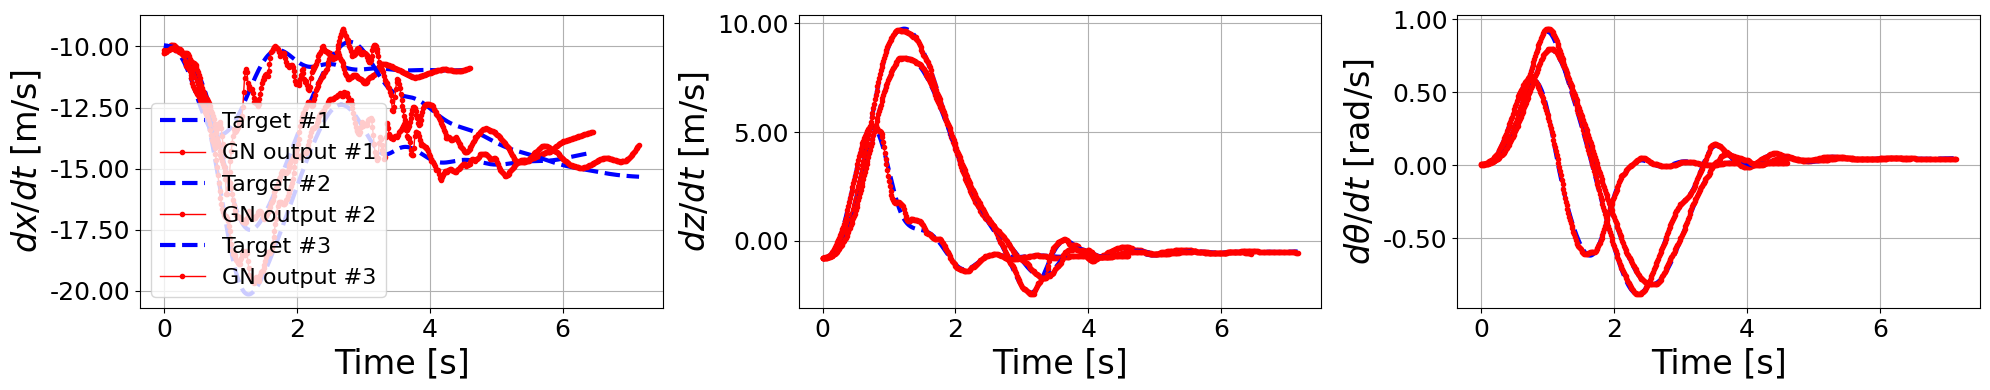

In [146]:

idxs_start_np=np.where((tfgraphs_in_tr_nsh[4][0:-(delta_shift+1),0]-tfgraphs_in_tr_nsh[4][1:-delta_shift,0])<-1)[0]
idxs_end_np = np.hstack([idxs_start_np,tfgraphs_in_tr_nsh[4].numpy().shape[0]-1])-delta_shift
idxs_start_np = np.hstack([0,idxs_start_np+1])

idxs_start=list(idxs_start_np)
idxs_end=list(idxs_end_np)


print(idxs_start)
print(directory)
plot_object(idx_object=4,n_object=1,list_tss=idxs_start[0:3],list_tse=idxs_end[0:3],graph_target=tfgraphs_tar_tr_nsh,graph_out=tfgraphs_out_tr_nsh,filename_fig='Out_vs_tar_tr_') #globals

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


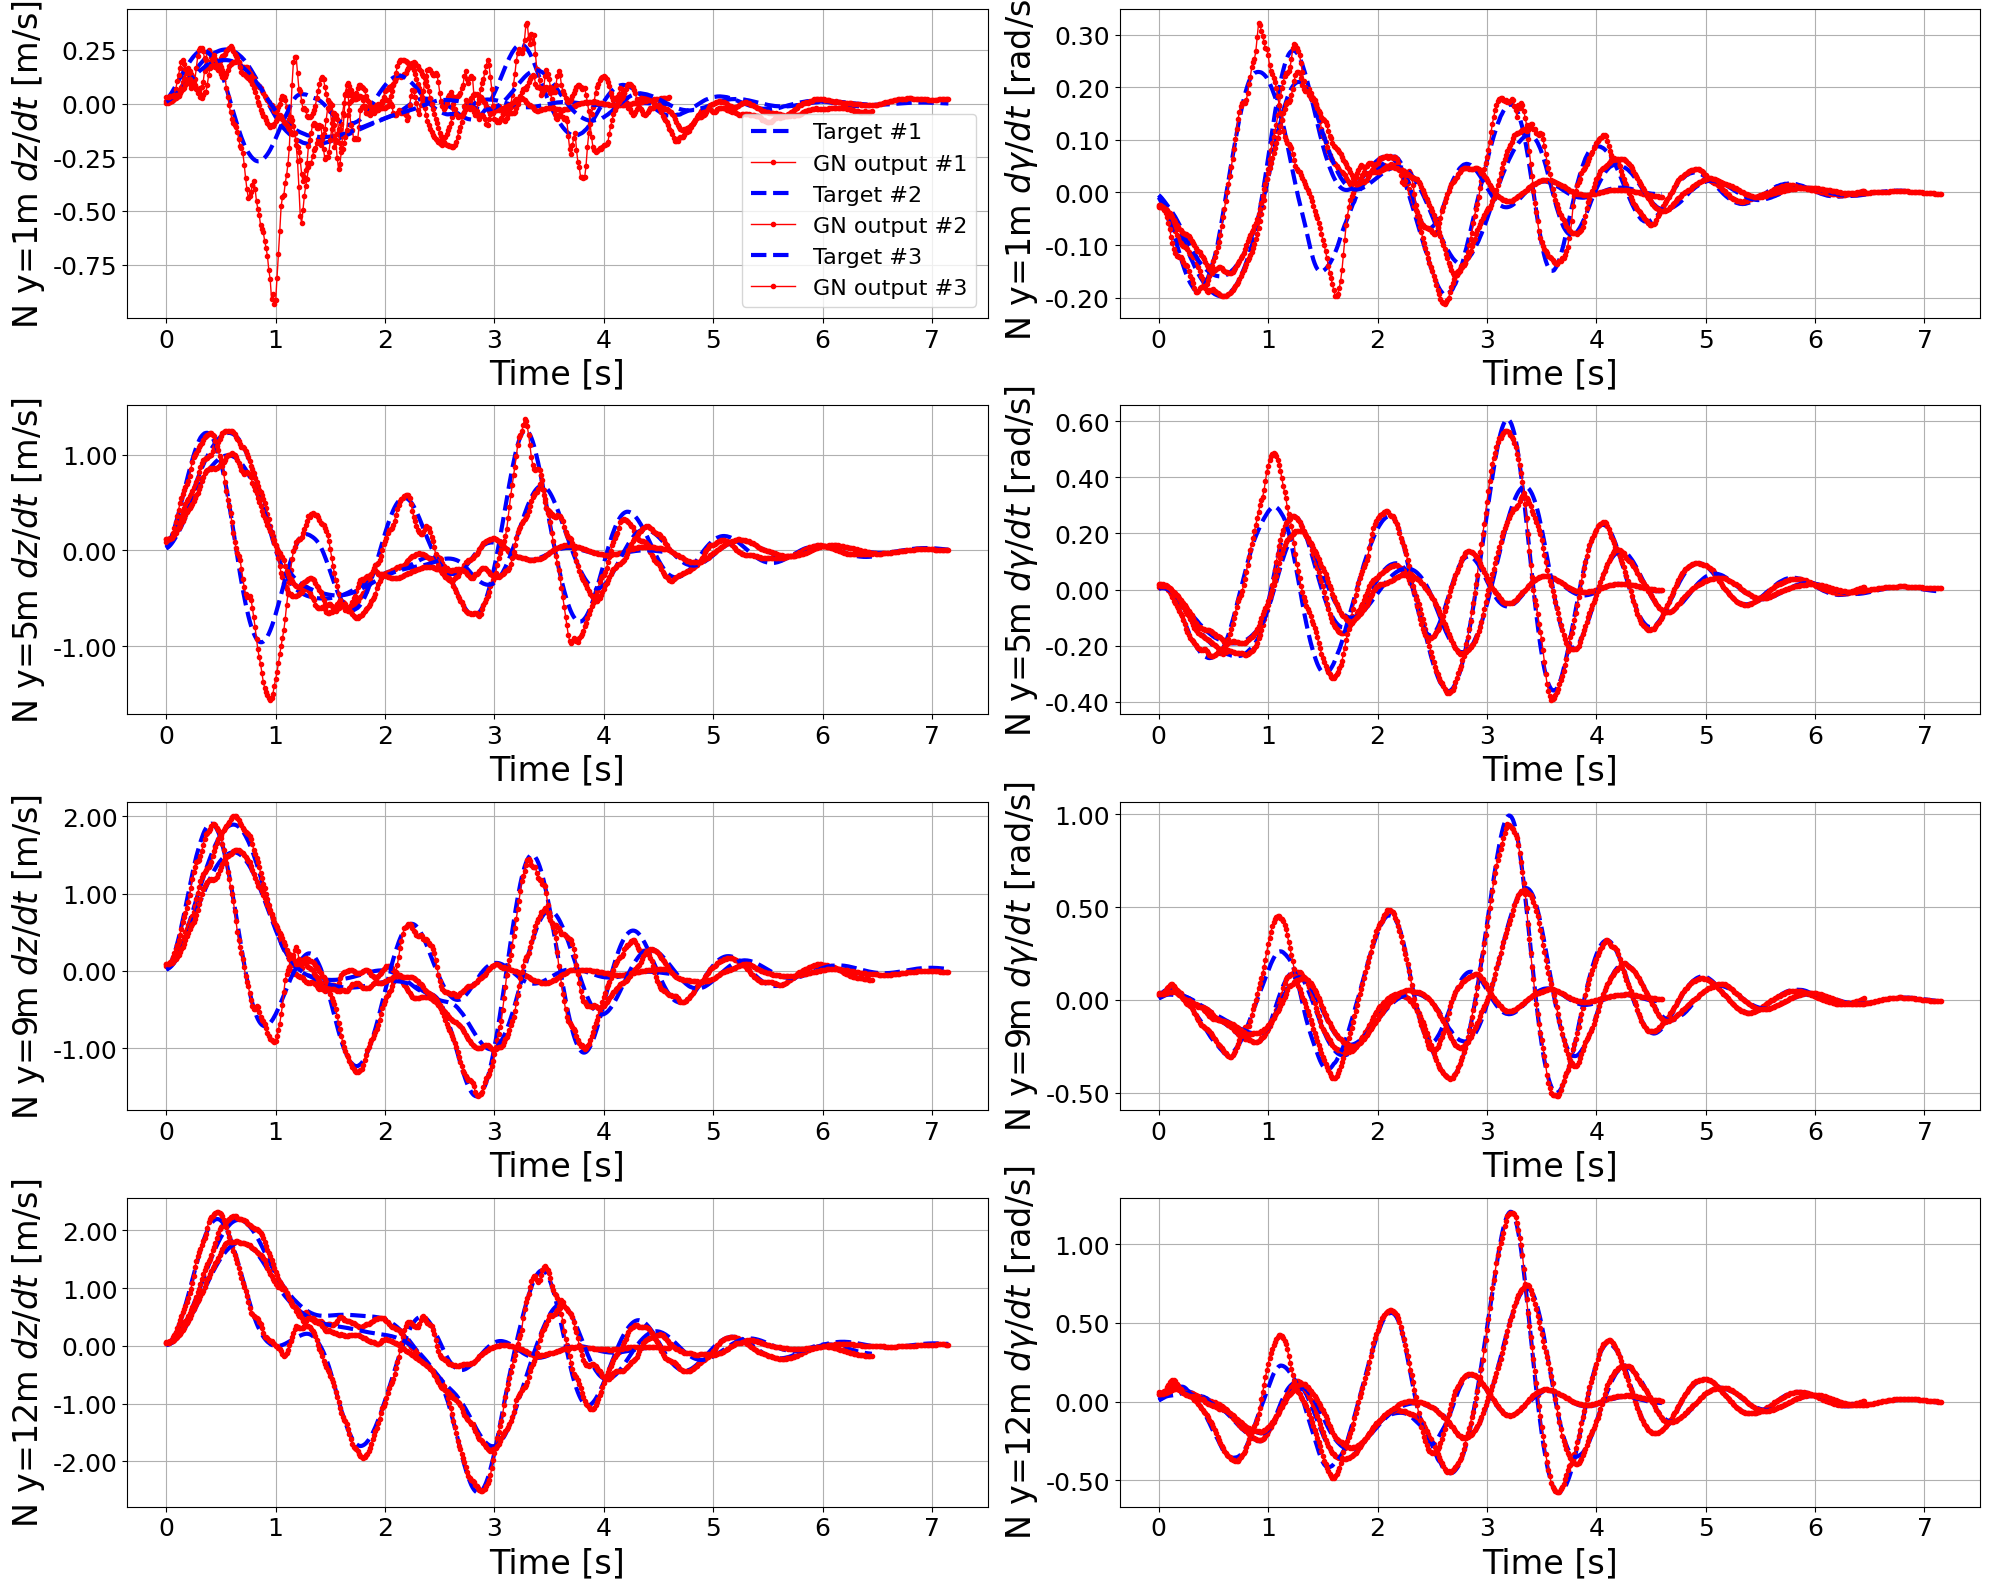

In [147]:
plot_object(idx_object=0,n_object=9,list_tss=idxs_start[0:3],list_tse=idxs_end[0:3],graph_target=tfgraphs_tar_tr_nsh,graph_out=tfgraphs_out_tr_nsh,filename_fig='Out_vs_tar_tr_') #nodes tr


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


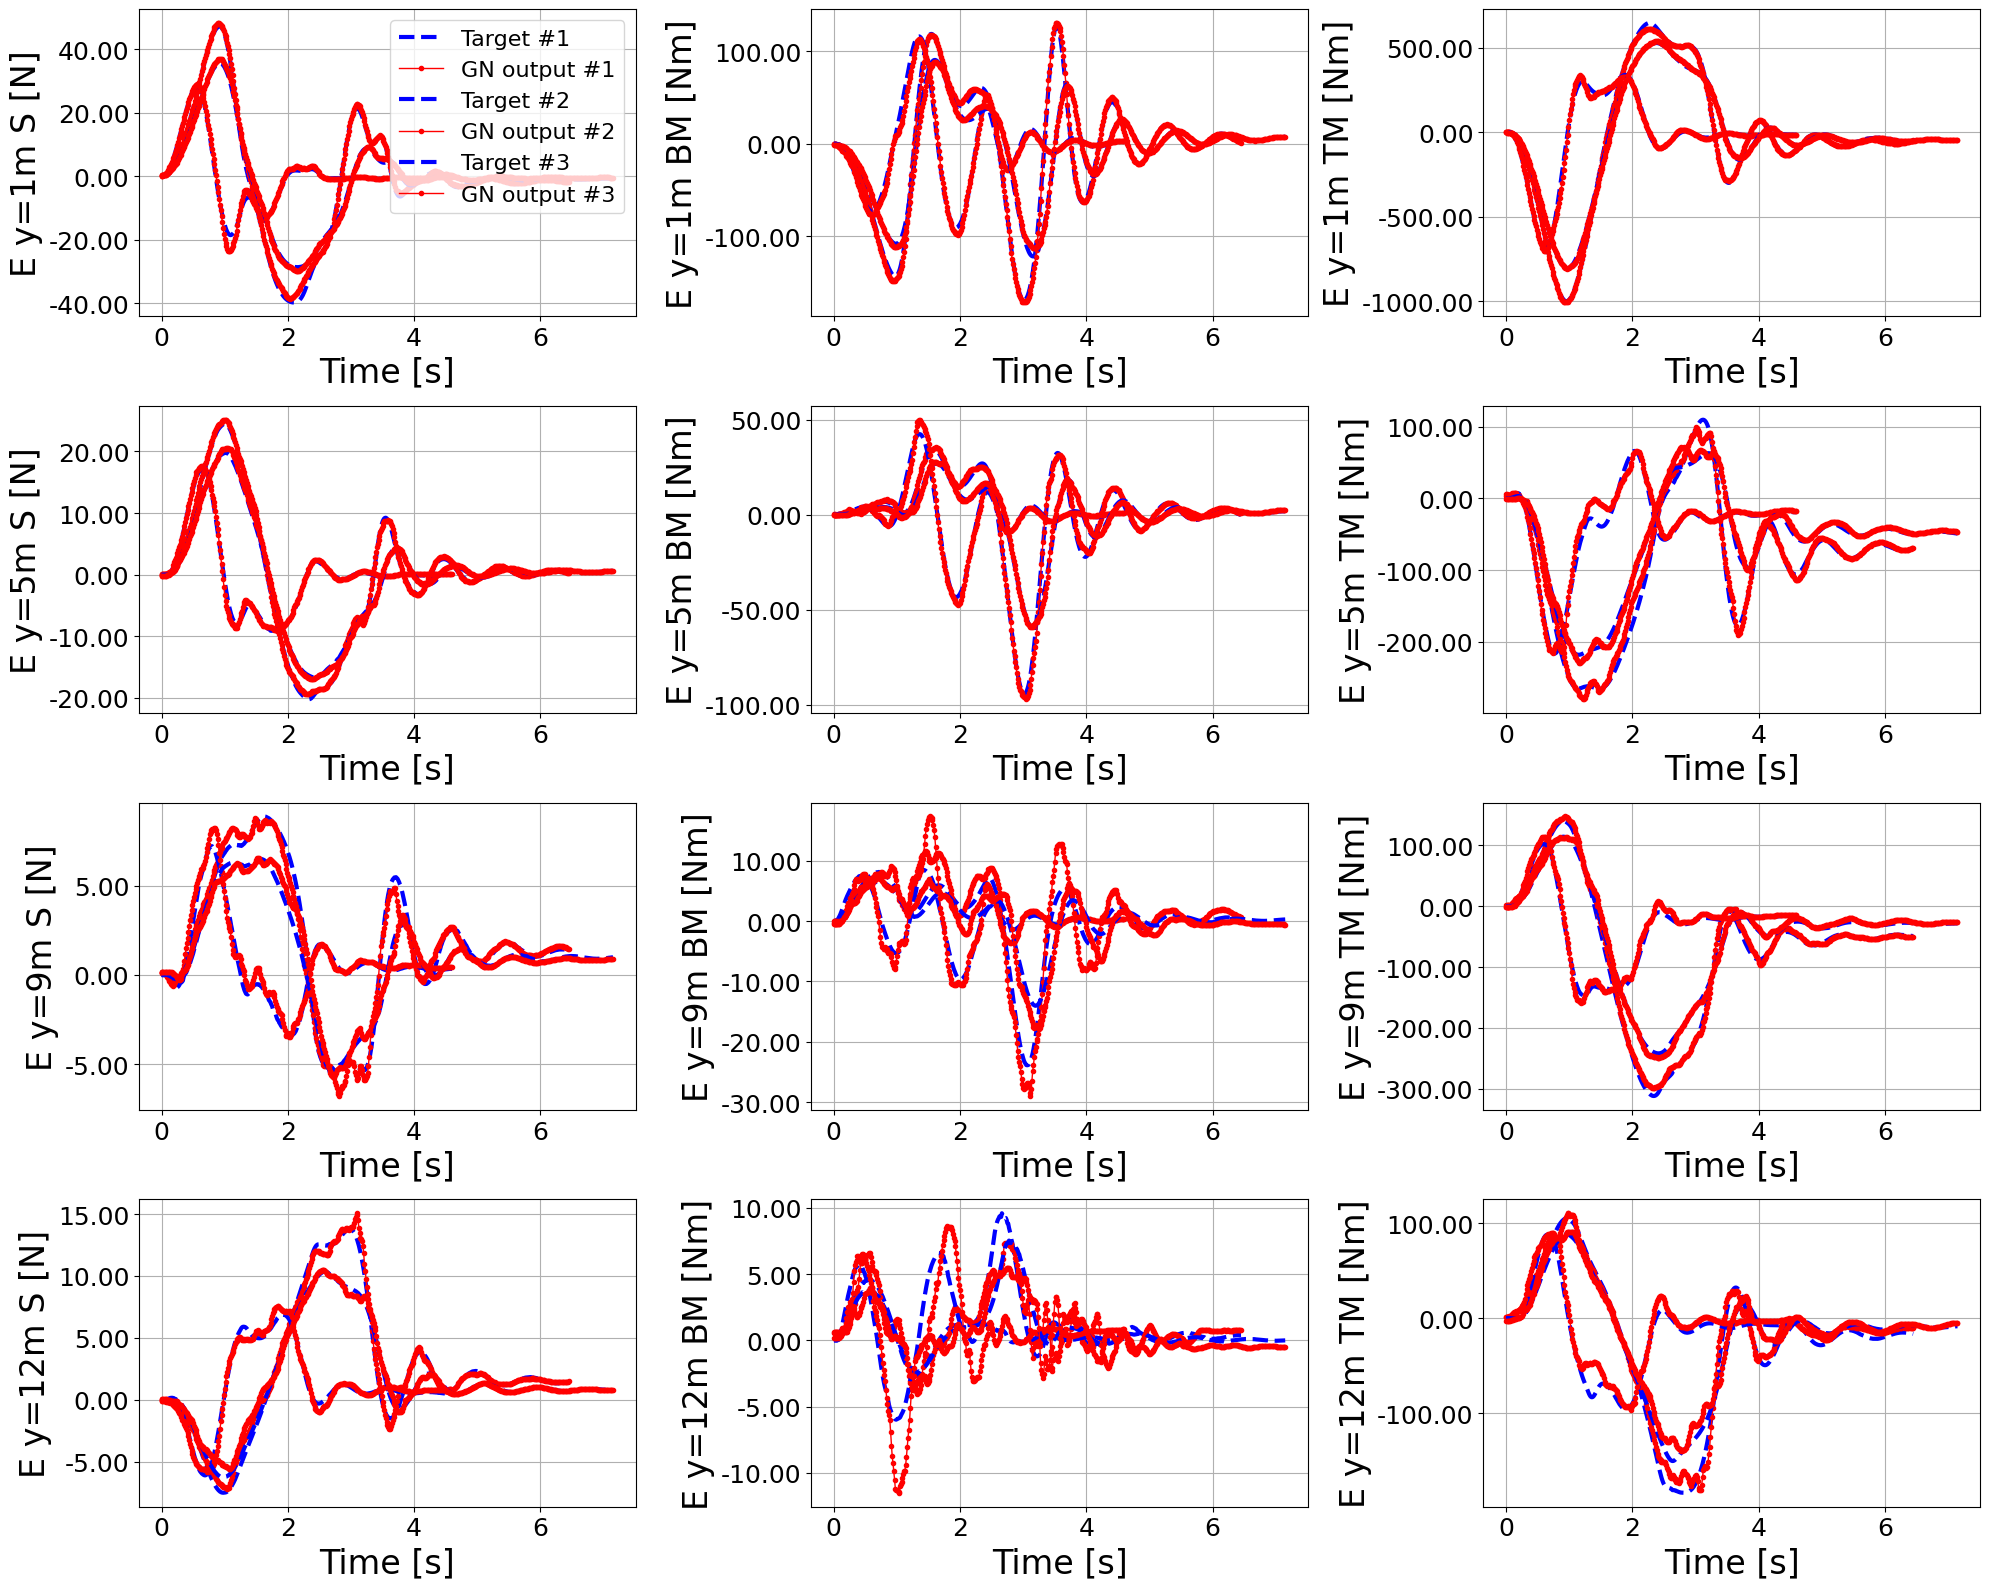

In [148]:
plot_object(idx_object=1,n_object=8,list_tss=idxs_start[0:3],list_tse=idxs_end[0:3],graph_target=tfgraphs_tar_tr_nsh,graph_out=tfgraphs_out_tr_nsh,filename_fig='Out_vs_tar_tr_') #loads tr


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0, 132, 698, 1046, 1420, 1844, 2373, 2764, 3003, 3538, 3897, 4466]
[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]


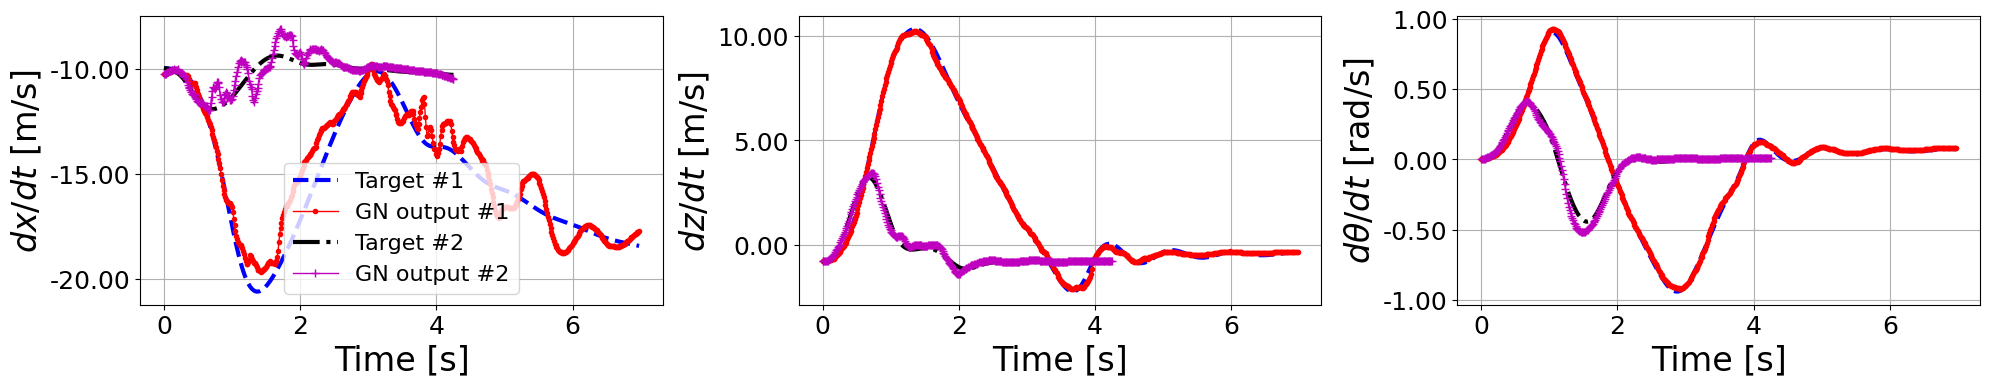

In [149]:


idxs_start_np=np.where((tfgraphs_in_va[4][0:-(delta_shift+1),0]-tfgraphs_in_va[4][1:-delta_shift,0])<-1)[0]

idxs_end_np = np.hstack([idxs_start_np,tfgraphs_in_va[4].numpy().shape[0]-1])
idxs_start_np = np.hstack([0,idxs_start_np+1])

idxs_start=list(idxs_start_np)
idxs_end=list(idxs_end_np-delta_shift)

print(idxs_start)


plot_object(idx_object=4,n_object=1,list_tss=idxs_start[1:3],list_tse=idxs_end[1:3],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va,filename_fig='Out_vs_tar_va_') #globals

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


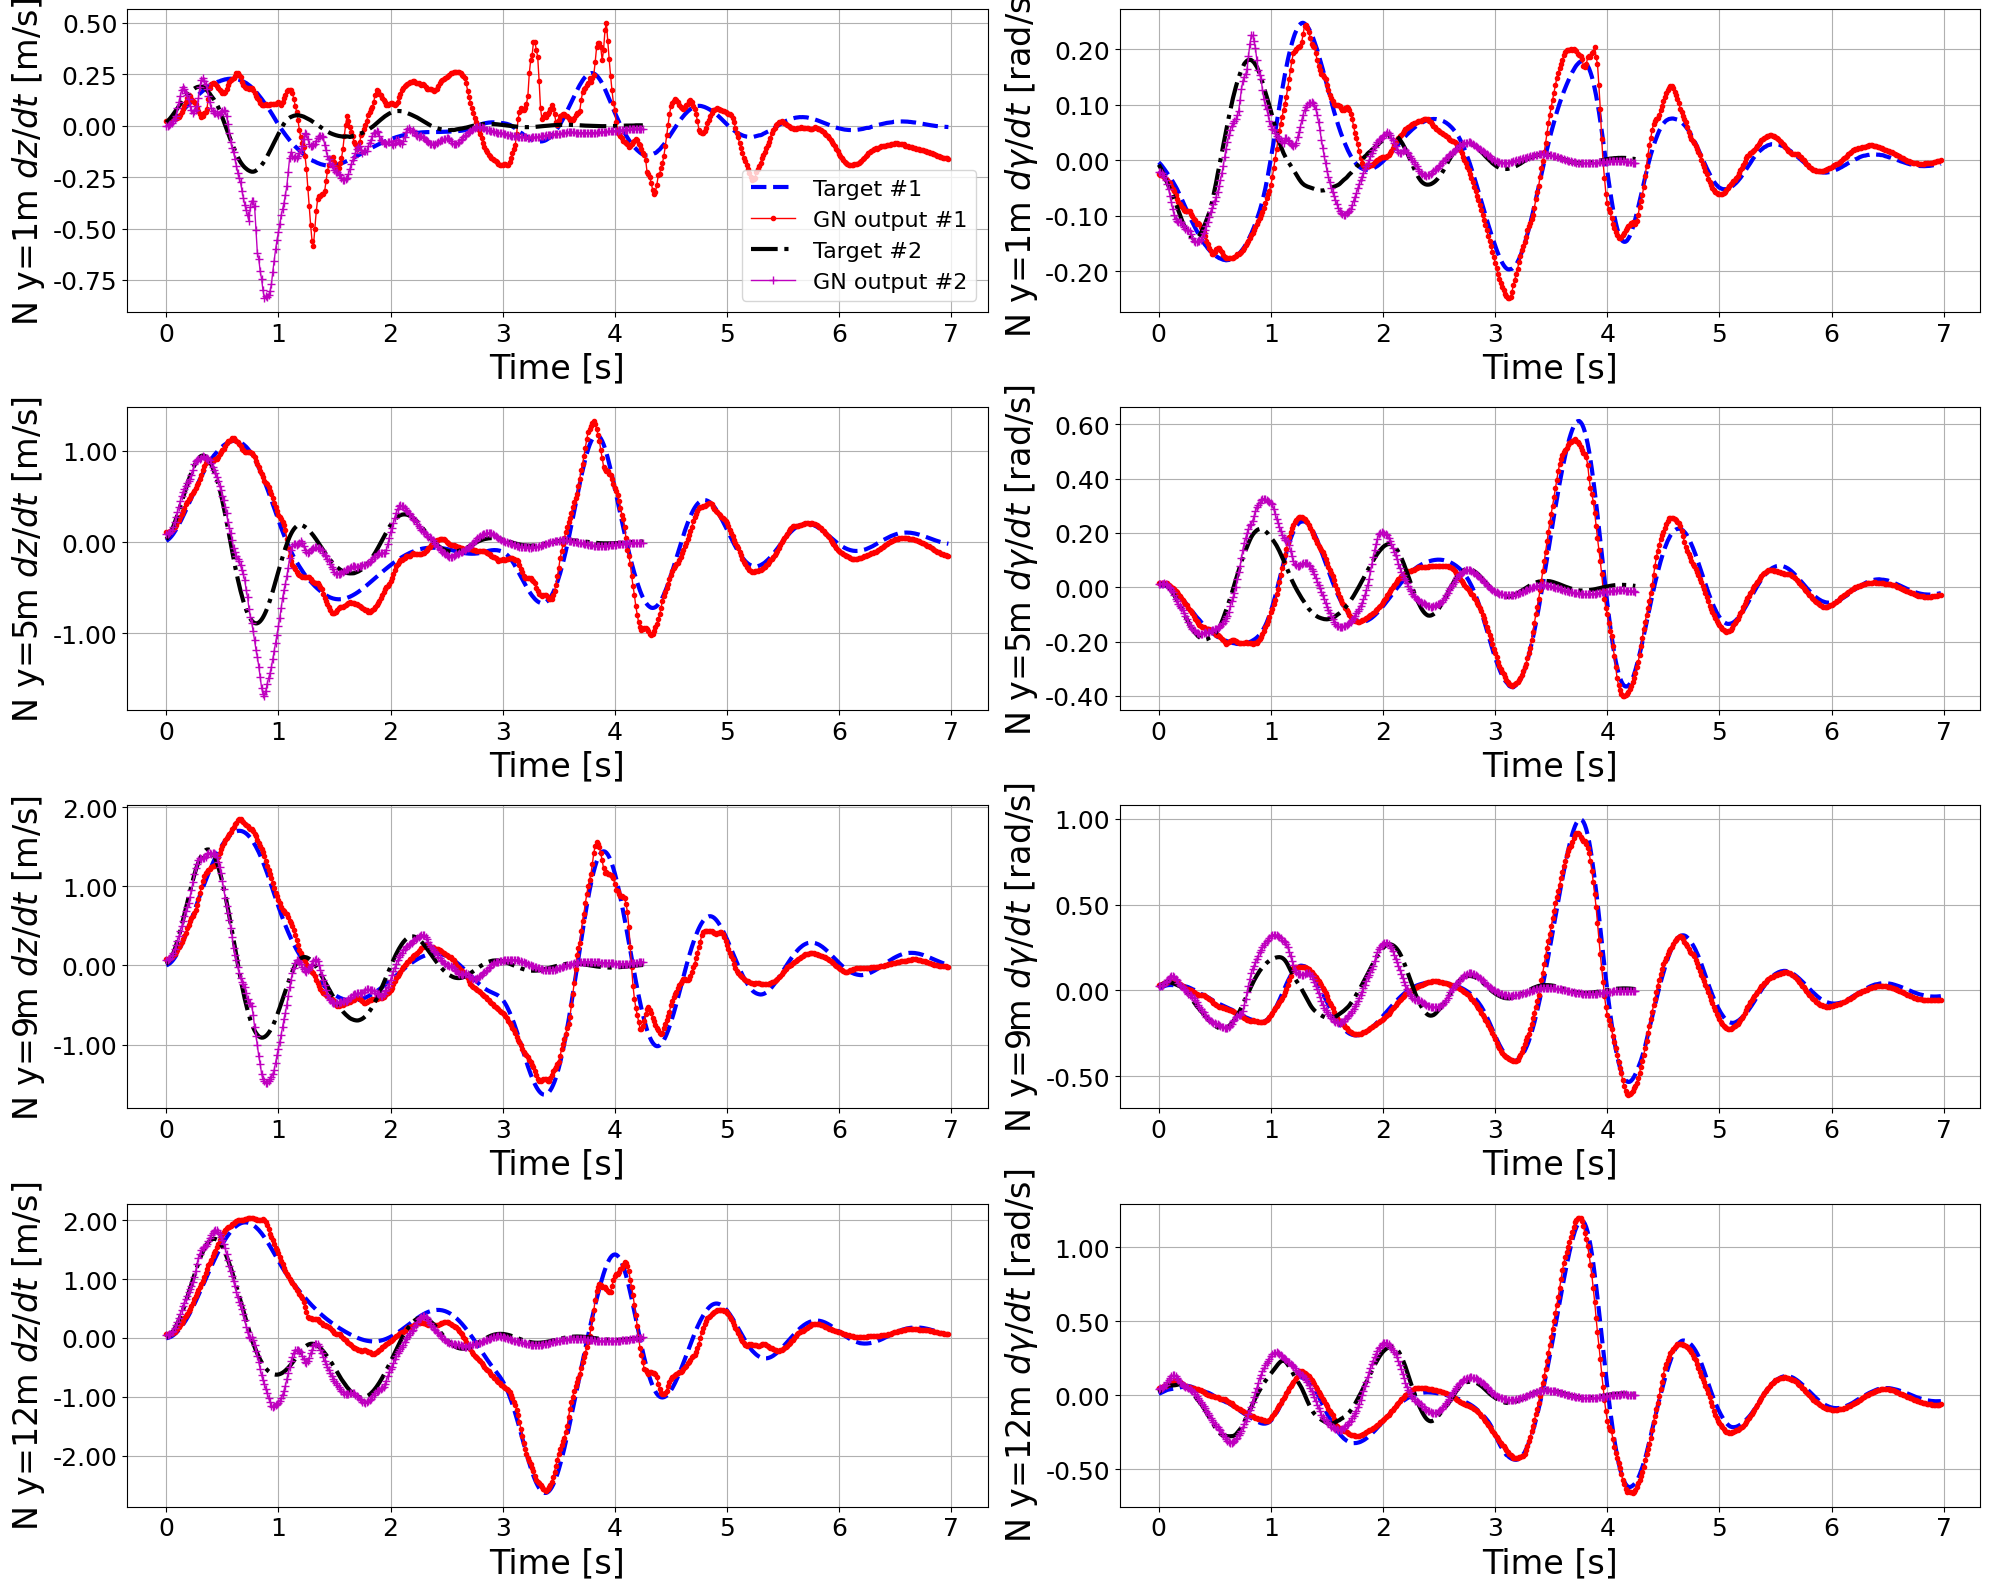

In [150]:
plot_object(idx_object=0,n_object=9,list_tss=idxs_start[1:3],list_tse=idxs_end[1:3],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va,filename_fig='Out_vs_tar_va_') #nodes va


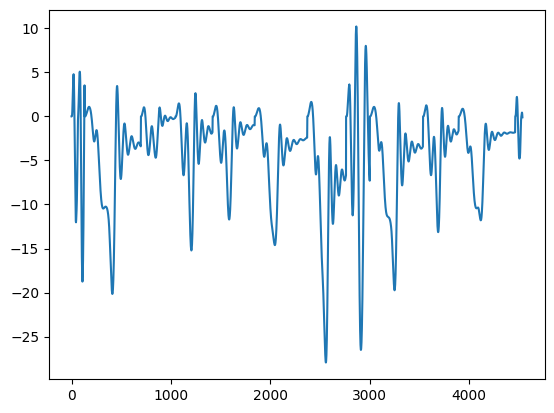

In [151]:
plt.plot(tfgraphs_in_va[0][7:-1:9,2]*57.3)
#plt.plot(np.diff(tfgraphs_in_va[0][7:-1:9,2])/0.0125,'r--' )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


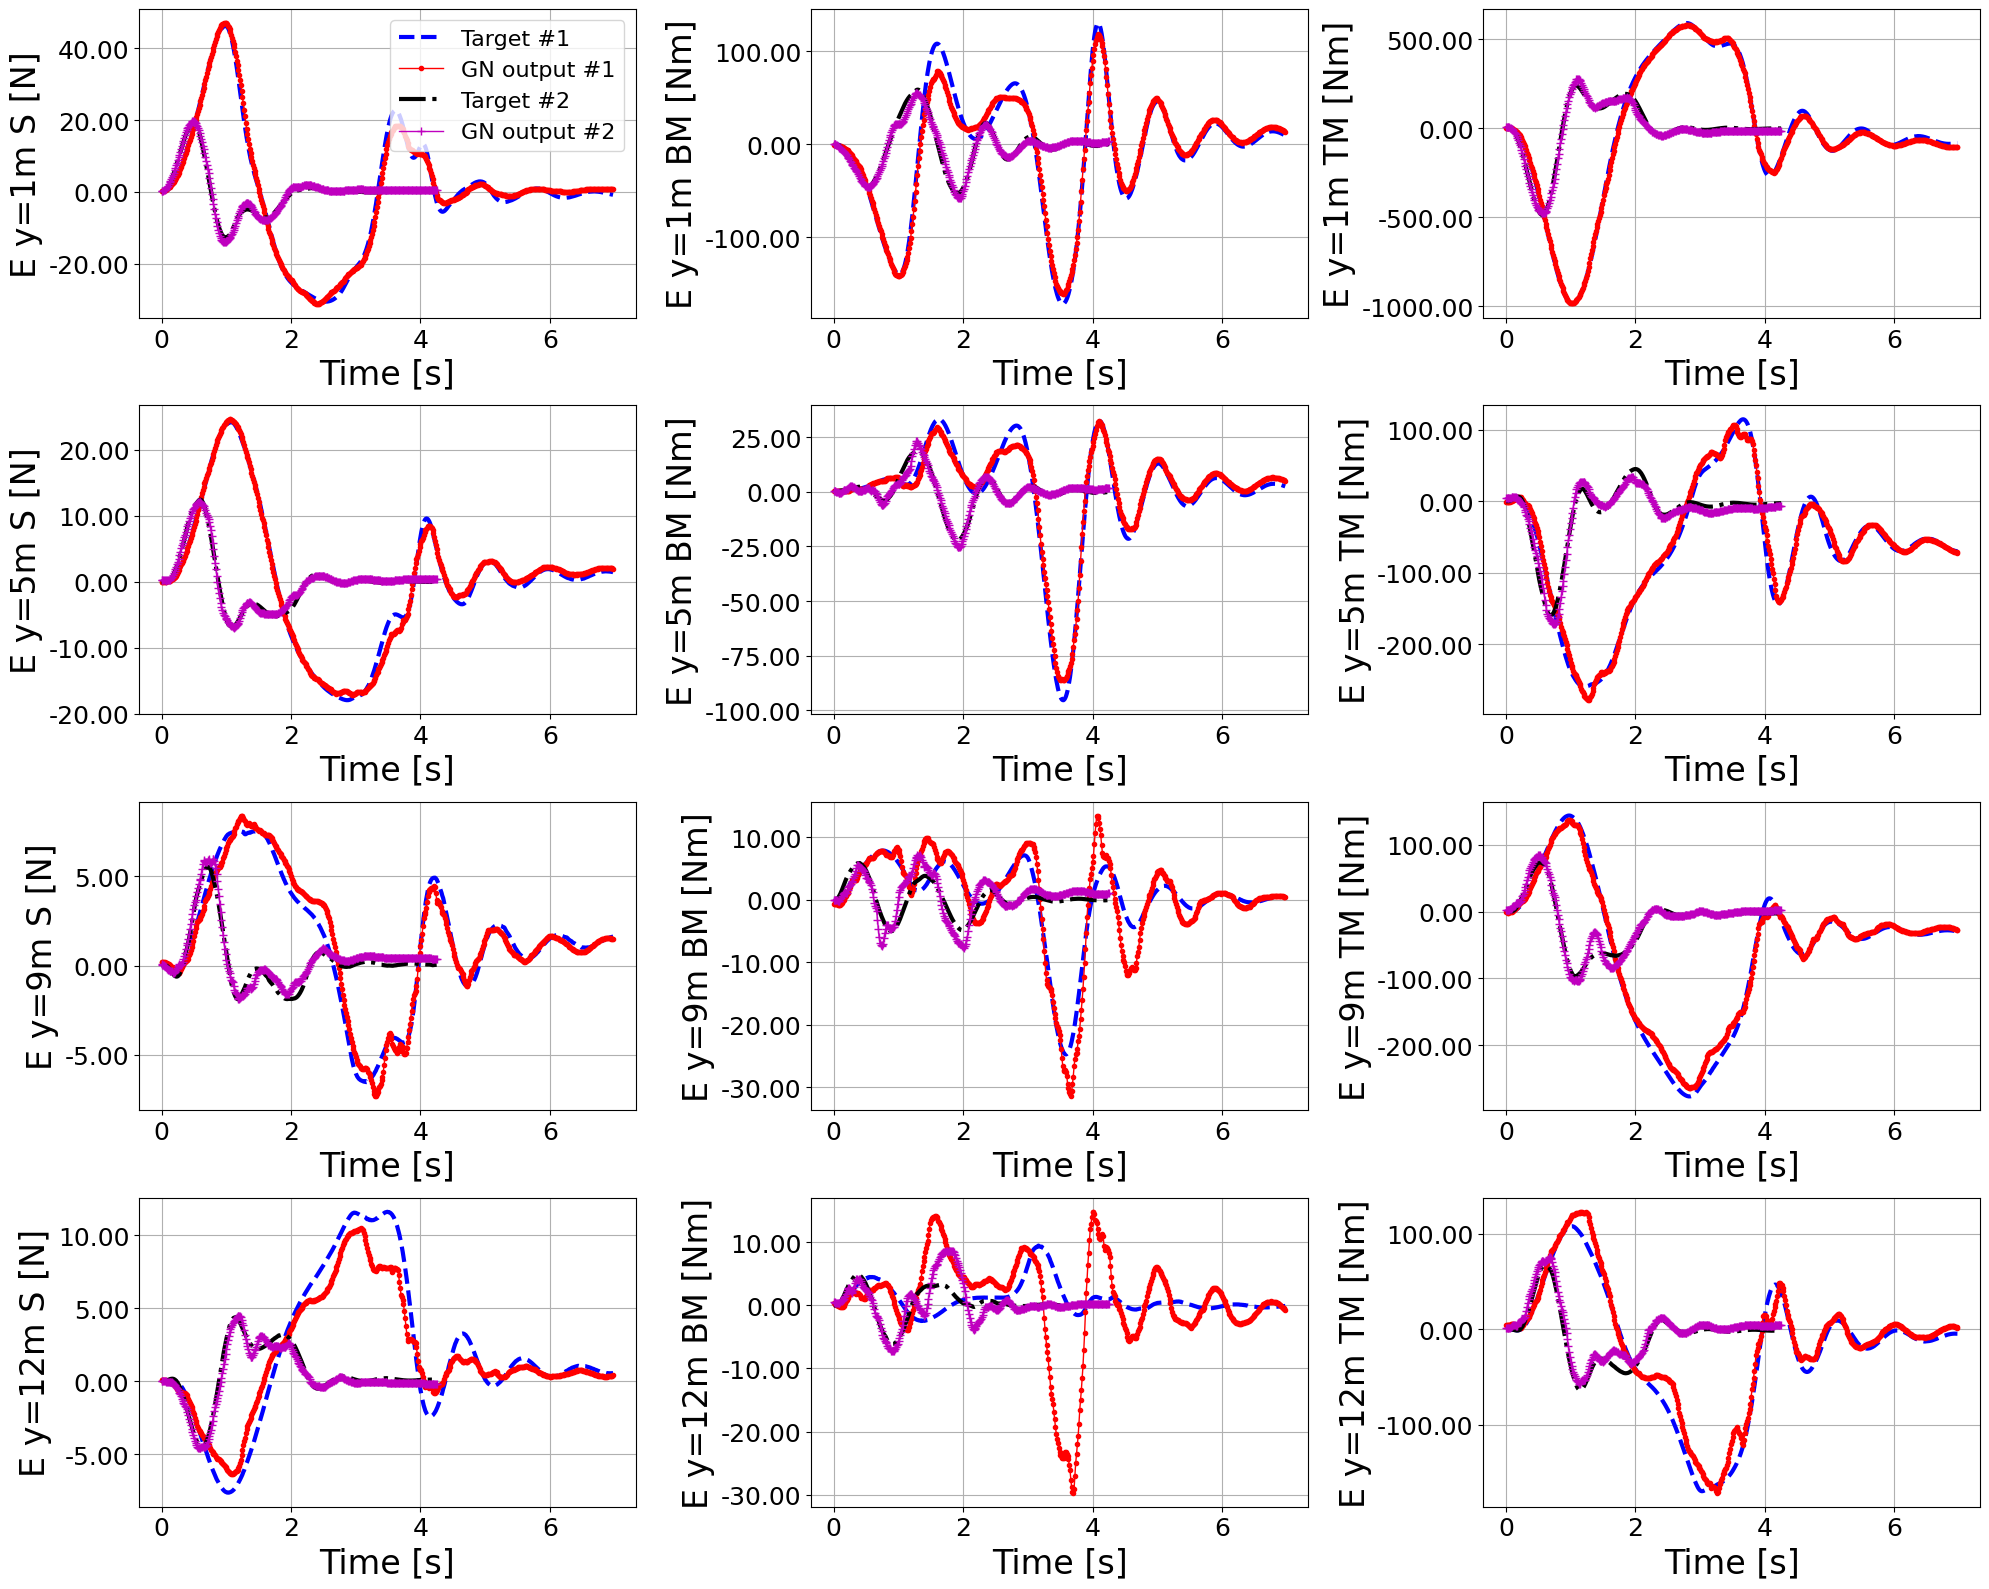

In [152]:
plot_object(idx_object=1,n_object=8,list_tss=idxs_start[1:3],list_tse=idxs_end[1:3],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va,filename_fig='Out_vs_tar_va_') #loads valid


In [153]:


def plotError(errE,errN,errG,errtype='Err'):

    y=np.int32(tfgraphs_in_va[0][0:9,0].numpy())
    yv = [str(int(yy)) for yy in y]

    ax= plt.subplots(1,3,figsize=(20,6),gridspec_kw={'width_ratios': [0.5,1, 1]})
   
    ax[1][1].set_xticks(np.arange(0, errE.shape[1],1))
    ax[1][1].set_yticks(np.arange(0, errE.shape[0],1))
    ax[1][1].tick_params(axis='both', which='major', labelsize=16)
    ax[1][1].tick_params(axis='both', which='minor', labelsize=16)
  
    ax[1][1].set_xlabel('Load Component',fontsize=18)
    ax[1][1].set_ylabel('Edge Y axis tip position',fontsize=18)
    ax[1][1].set_yticklabels(yv[1:])
    ax[1][1].set_xticklabels(['$S^*$','$BM^*$','$TM^*$'])

    
    
     
   

    pos0 = ax[1][1].imshow(errE)
    cbar=ax[0].colorbar(pos0, ax=ax[1][1])    
    cbar.ax.tick_params(labelsize=16) 

    ax[1][2].set_xticks(np.arange(0, errN.shape[1],1))
    ax[1][2].set_yticks(np.arange(0, errN.shape[0],1))
    ax[1][2].tick_params(axis='both', which='major', labelsize=16)
    ax[1][2].tick_params(axis='both', which='minor', labelsize=16)
  
    ax[1][2].set_xlabel('Node Component',fontsize=18)
    ax[1][2].set_ylabel('Node Y axis position',fontsize=18)
    ax[1][2].set_yticklabels(yv)
    ax[1][2].set_xticklabels(['$dz/dt^*$ ','$d\\gamma/dt^*$ '])
    pos1 = ax[1][2].imshow(errN)
    cbar=ax[0].colorbar(pos1, ax=ax[1][2])
    cbar.ax.tick_params(labelsize=16) 

    ax[1][0].set_xticks(np.arange(0, errG.shape[0]-2,1))
    ax[1][0].set_xlabel('Global Component',fontsize=18)
    ax[1][0].tick_params(axis='both', which='major', labelsize=16)
    ax[1][0].tick_params(axis='both', which='minor', labelsize=16)
  
    pos2 = ax[1][0].bar(np.arange(0, errG.shape[0]-2,1),errG[0:3])
    ax[1][0].set_xticklabels(['$dx/dt^*$ ','$dz/dt^*$ ','$d\\theta/dt^*$ '])
    plt.tight_layout()    
    plt.savefig(os.path.join(directory,errtype+'.eps'), format='eps')
    plt.show()

    



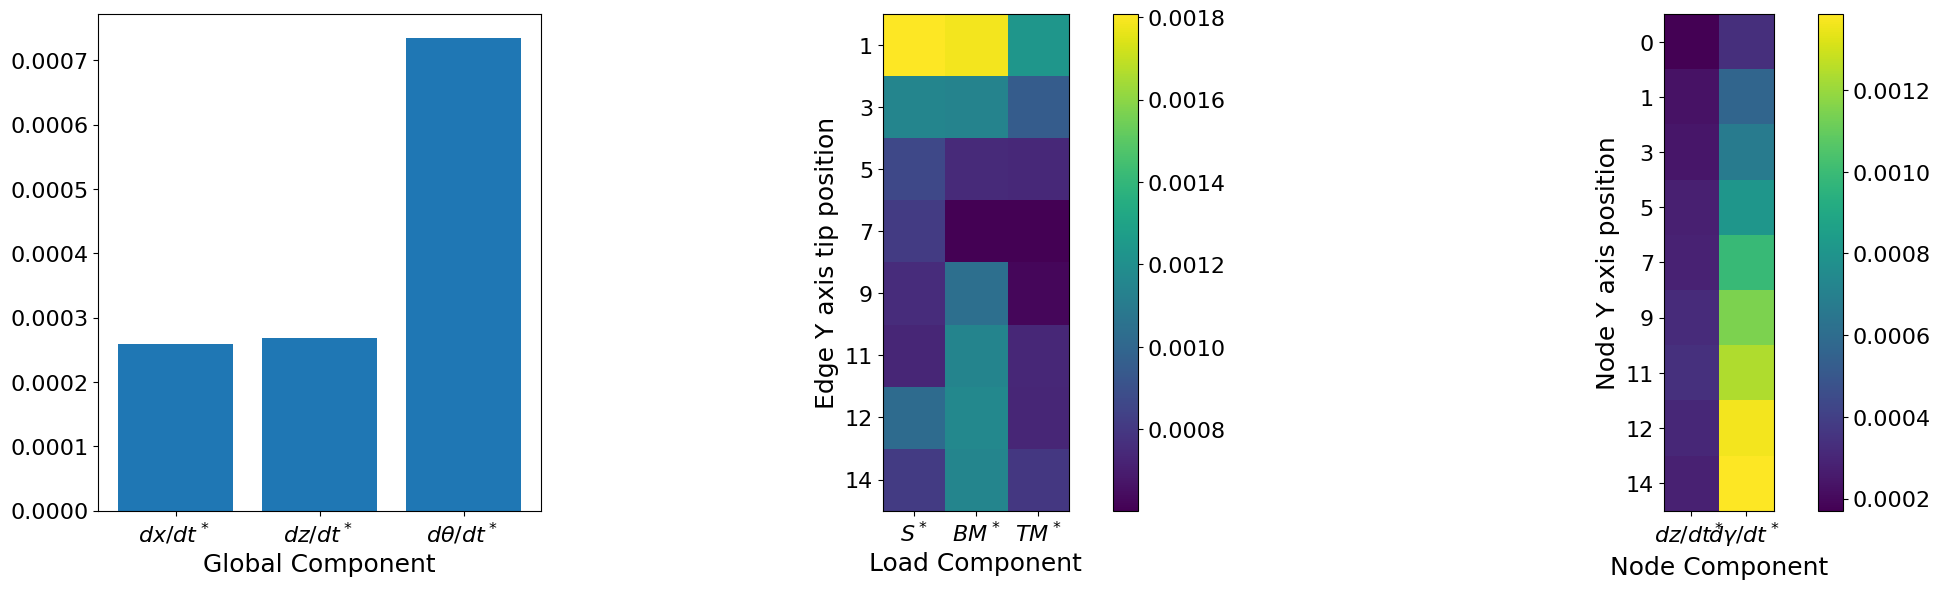

In [154]:
plotError(mseE,mseN,mseG,errtype='RMSE')

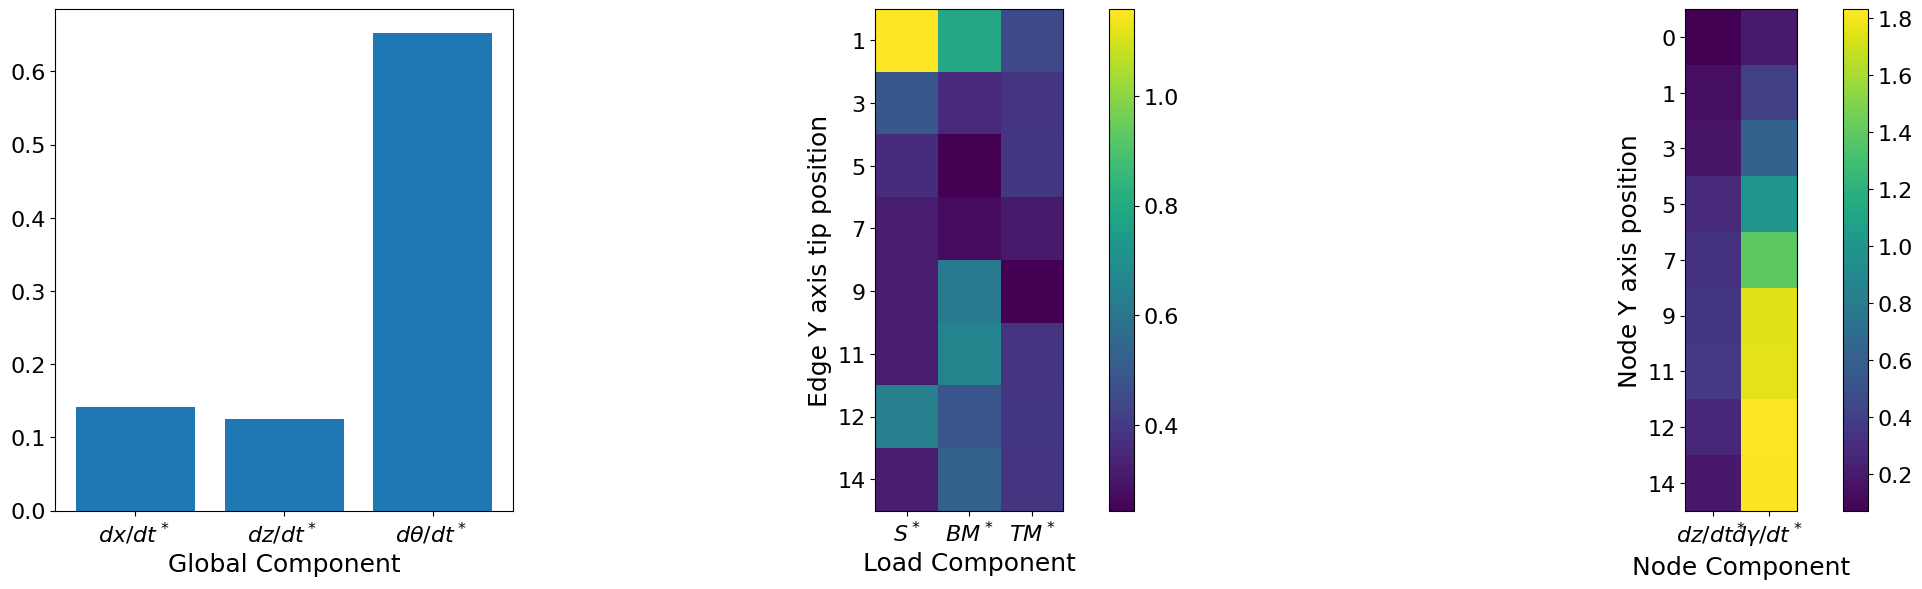

In [155]:
plotError(maeE,maeN,maeG,errtype='MAE')

#Roll out 

In [156]:


def roll_out(in_start,tlen,model_ro,graph_in,graph_tar,delta_shift=1,dt=0.0125):
    
    
    tfgraph_in_ro=utils_tf.data_dicts_to_graphs_tuple([graph_in[in_start]]) 
    tfgraph_in_ro_norm = normalize_graph(tfgraph_in_ro,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
    graphs_ro_out=list()
    graphs_ro_tar=list()
    
    tfgraph_step_in_norm=tfgraph_in_ro_norm
       


    for t in range(tlen):       

       
        #single step of computation  
        tfgraph_step_out_norm=model_ro(tfgraph_step_in_norm,1)        
        
        #denormalize graph in and out of current s
        tfgraph_step_out = denormalize_graph(tfgraph_step_out_norm,var_nodesout,mean_nodesout,var_edgesout,mean_edgesout,var_globalsout,mean_globalsout)
        tfgraph_step_in = denormalize_graph(tfgraph_step_in_norm,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
        
        graph_step_out = utils_np.graphs_tuple_to_data_dicts(tfgraph_step_out)[0]
        graph_step_in = utils_np.graphs_tuple_to_data_dicts(tfgraph_step_in)[0]    

        nodes_out=graph_step_out['nodes'].copy()
        nodes_in=graph_step_in['nodes'].copy()

        #i do a simple 1 time step integration with forward Euler Method and then i update the derivatives 
        nodes_in[:,0]=nodes_in[:,0]
        nodes_in[:,1]=nodes_in[:,3]*dt+nodes_in[:,1]
        nodes_in[:,2]=nodes_in[:,4]*dt+nodes_in[:,2]    
        nodes_in[:,3:5]=nodes_out[:,0:2]            
        nodes_in[:,5]=graph_in[in_start+(t+1)*delta_shift]['nodes'][:,-1] #lumped mass reported from initial graph
        
        
        globs_out=graph_step_out['globals'].copy()
        globs_in=graph_step_in['globals'].copy()
        globs_in[0]=globs_in[5]*dt+globs_in[0]
        globs_in[1]=globs_in[6]*dt+globs_in[1]
        globs_in[2]=globs_in[7]*dt+globs_in[2]
        globs_in[3]=globs_in[8]*dt+globs_in[3]
        globs_in[4]=globs_in[9]*dt+globs_in[4]        
        globs_in[5:10]=globs_out[0:5] 
        globs_in[-1]= graph_in[in_start+(t+1)*delta_shift]['globals'][-1] #wind input
        
                
        #edges are the structural properties. they are actually unchanged but i read them from next time step
        graph_in_next_step = { "globals": globs_in,#np.hstack([graph_step[0]['globals'][0:-1], graph_in_va[in_start+t+1]['globals'][-1]]),
                       "nodes":   nodes_in,# graph_step[0]['nodes'],
                       "edges":   graph_in[in_start+(t+1)*delta_shift]['edges'],
                       "receivers": graph_in[0]['receivers'],
                       "senders": graph_in[0]['senders']
                             }
     
        
        graphs_ro_out.append(graph_step_out) 
        graphs_ro_tar.append(graph_tar[in_start+(t)*delta_shift])        

        tfgraph_step_in=utils_tf.data_dicts_to_graphs_tuple([graph_in_next_step])
        tfgraph_step_in_norm = normalize_graph(tfgraph_step_in,var_nodesin,mean_nodesin,var_edgesin,mean_edgesin,var_globalsin,mean_globalsin)
   
    return graphs_ro_out,graphs_ro_tar

In [157]:


idxs_start_np=np.where((tfgraphs_in_tr_nsh[4][0:-(delta_shift+1),0]-tfgraphs_in_tr_nsh[4][1:-delta_shift,0])<-1)[0]

idxs_end_np = np.hstack([idxs_start_np,tfgraphs_in_tr_nsh[4].numpy().shape[0]-1])
idxs_start_np = np.hstack([0,idxs_start_np+1])

idxs_start=list(idxs_start_np)
idxs_end=list(idxs_end_np)


print(idxs_start)

[0, 524, 900, 1480, 1656, 2385, 2479, 2920, 3531, 4079, 4684, 5231, 5346, 5847, 6441, 6934, 7583, 7725, 8380, 8470, 9138, 9317, 10047, 10714, 11223, 11869, 12579, 12782, 12987, 13202, 13456, 13864, 14092, 14208, 14556, 14734, 14916, 15065, 15644, 15942, 16107, 16440, 17109, 17688, 18068, 18556]


In [175]:
idxs_start =[10,60]
dt=0.0125*delta_shift
n_glob=tfgraphs_out_va[4].shape[1]
tlen=50
tfgraphs_ro_out=list()
tfgraphs_ro_tar=list()
for i in  range(len(idxs_start)):    # range(len(idxs_start)):    
    idx_start=idxs_start[i]
    print(idx_start)
    start = time.time()
    graphs_ro_out,graphs_ro_tar =   roll_out(in_start=idx_start,graph_in=graph_in_tr,graph_tar=graph_tar_tr,tlen=tlen,model_ro=model,delta_shift=delta_shift,dt=dt)
    end = time.time()

    tfgraph_ro_out =utils_tf.data_dicts_to_graphs_tuple(graphs_ro_out) 
    tfgraph_ro_tar =utils_tf.data_dicts_to_graphs_tuple(graphs_ro_tar) 

    tfgraphs_ro_out.append(tfgraph_ro_out)
    tfgraphs_ro_tar.append(tfgraph_ro_tar)

   
tfgraphs_ro_out = utils_tf.concat(tfgraphs_ro_out,axis=0)
tfgraphs_ro_tar = utils_tf.concat(tfgraphs_ro_tar,axis=0)
print(tfgraphs_ro_tar[4].shape)

10
60
(100, 5)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 0 50]
[25 75]
[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]


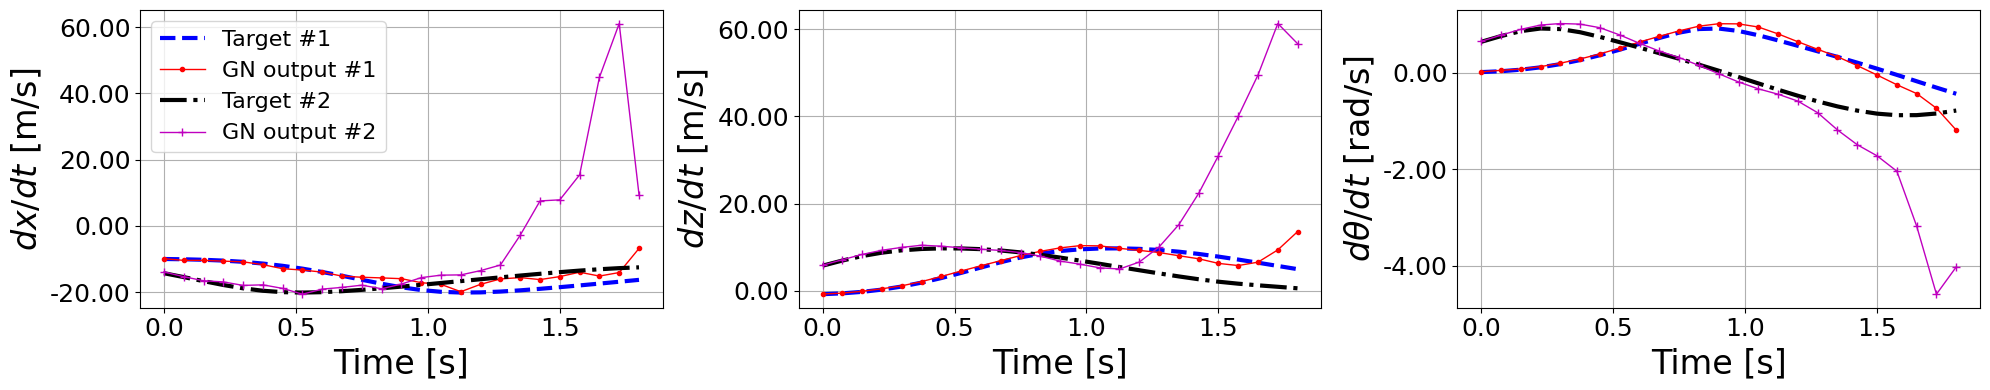

In [176]:

list_tss=np.arange(0,tfgraphs_ro_tar[4].shape[0],tlen)
list_tse=list_tss+int(tlen/2)
print(list_tss)
print(list_tse)
plot_object(idx_object=4,n_object=1,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out',dtloc=0.0125*6) #loads valid



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


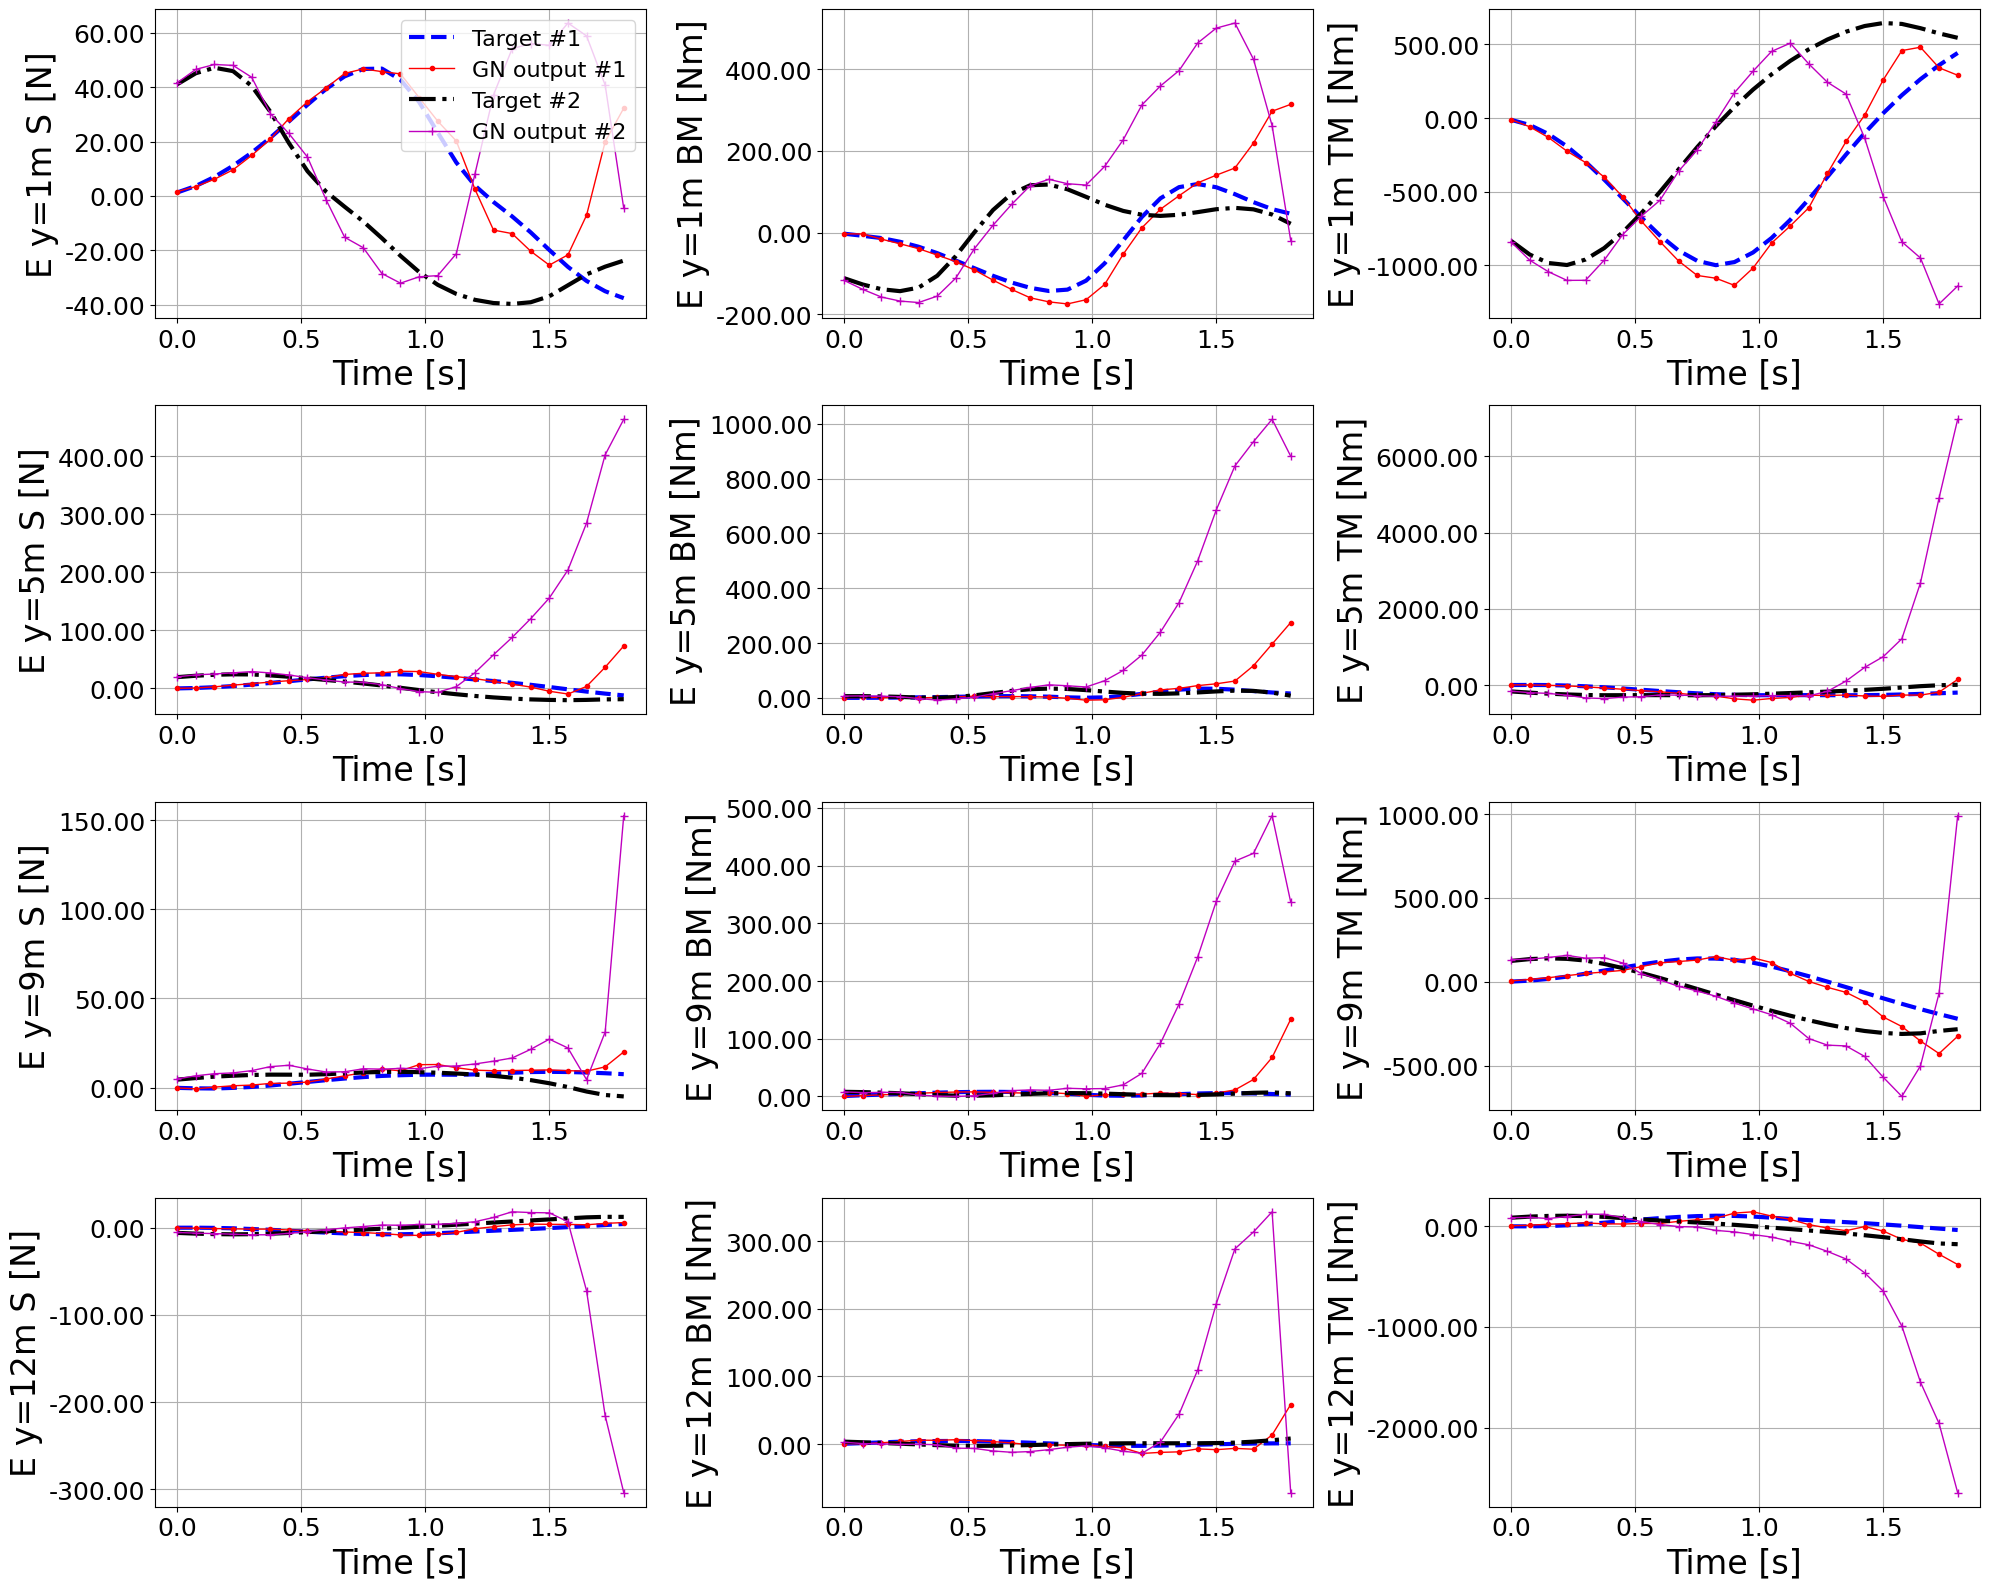

In [177]:
plot_object(idx_object=1,n_object=8,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out',dtloc=0.0125*6) #loads valid




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


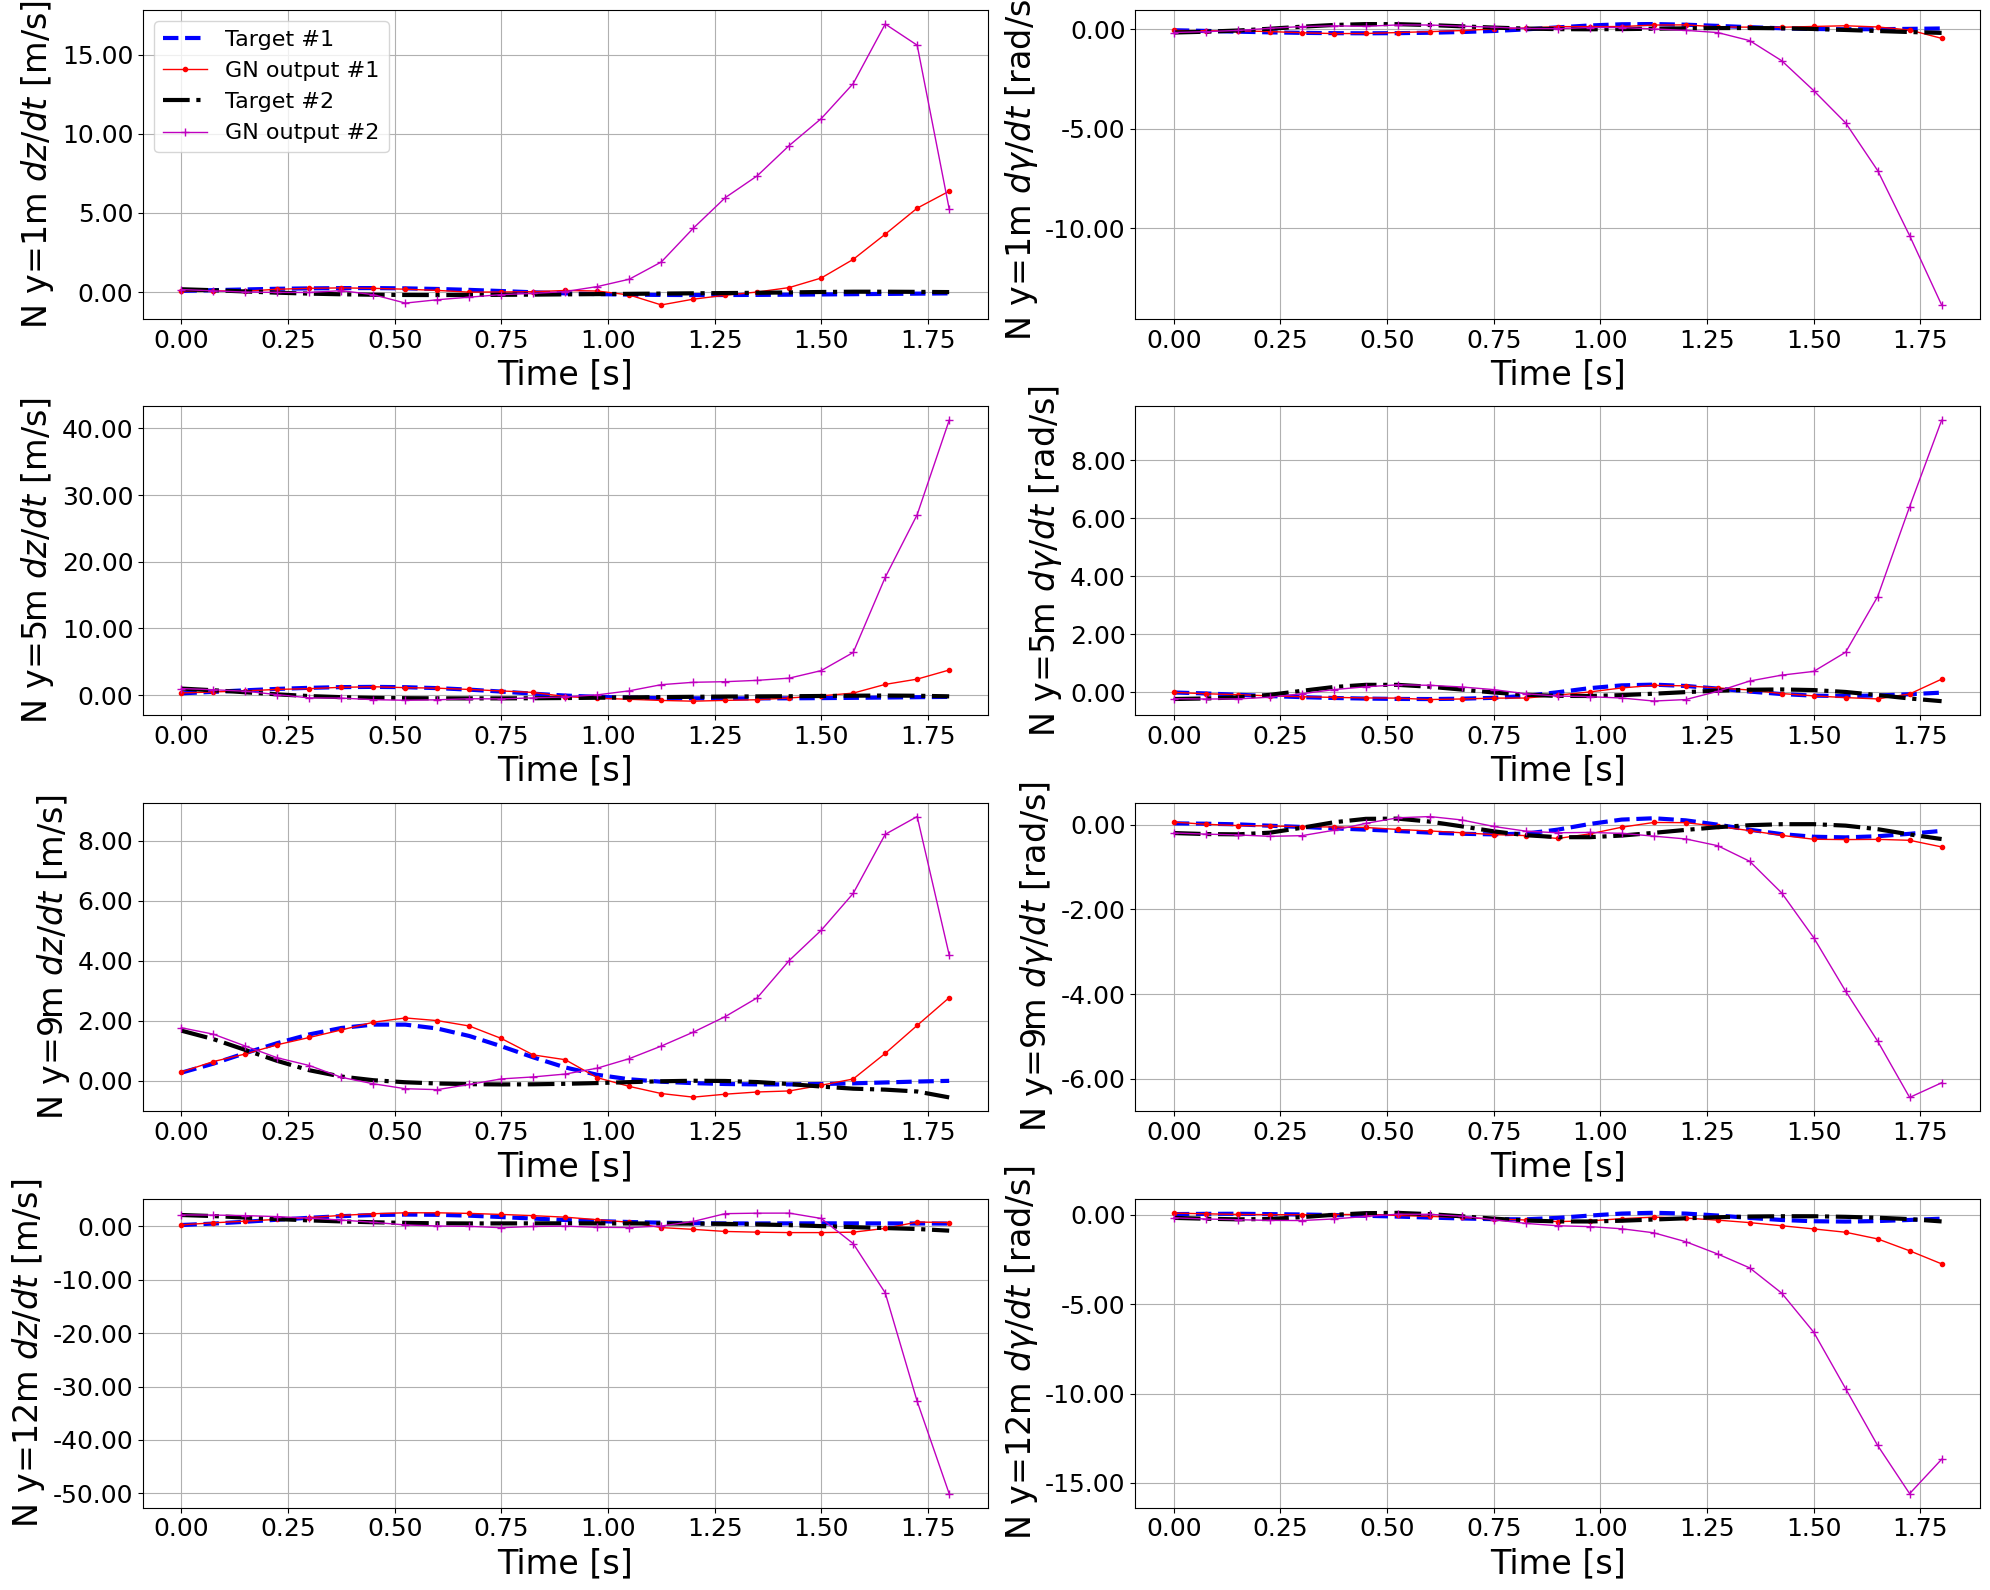

In [178]:
plot_object(idx_object=0,n_object=9,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out',dtloc=0.0125*6) #loads valid



[0, 132, 698, 1046, 1420, 1844, 2373, 2764, 3003, 3538, 3897, 4466]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]


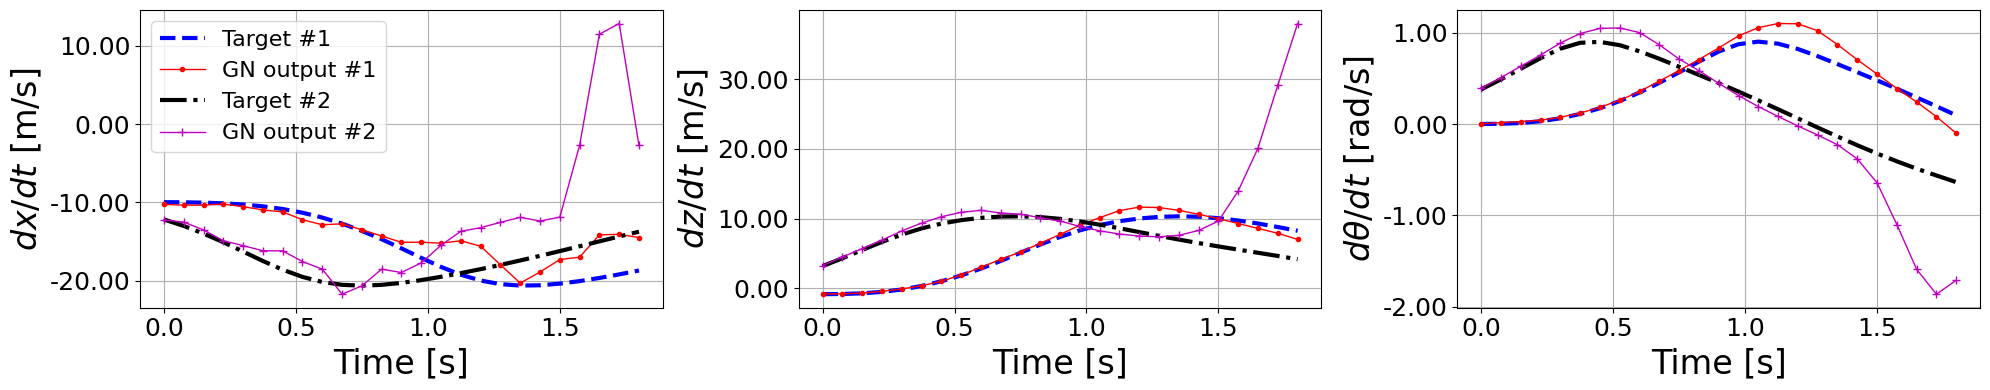

In [162]:


idxs_start_np=np.where((tfgraphs_in_va[4][0:-(delta_shift+1),0]-tfgraphs_in_va[4][1:-delta_shift,0])<-1)[0]

idxs_end_np = np.hstack([idxs_start_np,tfgraphs_in_va[4].numpy().shape[0]-1])
idxs_start_np = np.hstack([0,idxs_start_np+1])

idxs_start=list(idxs_start_np)
idxs_end=list(idxs_end_np)


print(idxs_start)

idxs_start = [132 , 182]
dt=0.0125*delta_shift
n_glob=tfgraphs_out_va[4].shape[1]
tlen=50
tfgraphs_ro_out=list()
tfgraphs_ro_tar=list()
for i in  range(len(idxs_start)):    # range(len(idxs_start)):    
    idx_start=idxs_start[i]
    start = time.time()
    graphs_ro_out,graphs_ro_tar =   roll_out(in_start=idx_start,graph_in=graph_in_va,graph_tar=graph_tar_va,tlen=tlen,model_ro=model,delta_shift=delta_shift,dt=dt)
    end = time.time()

    tfgraph_ro_out =utils_tf.data_dicts_to_graphs_tuple(graphs_ro_out) 
    tfgraph_ro_tar =utils_tf.data_dicts_to_graphs_tuple(graphs_ro_tar) 

    tfgraphs_ro_out.append(tfgraph_ro_out)
    tfgraphs_ro_tar.append(tfgraph_ro_tar)

   
tfgraphs_ro_out = utils_tf.concat(tfgraphs_ro_out,axis=0)
tfgraphs_ro_tar = utils_tf.concat(tfgraphs_ro_tar,axis=0)

list_tss=np.arange(0,100,tlen)
plot_object(idx_object=4,n_object=1,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out_valid',dtloc=dt) #loads valid



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


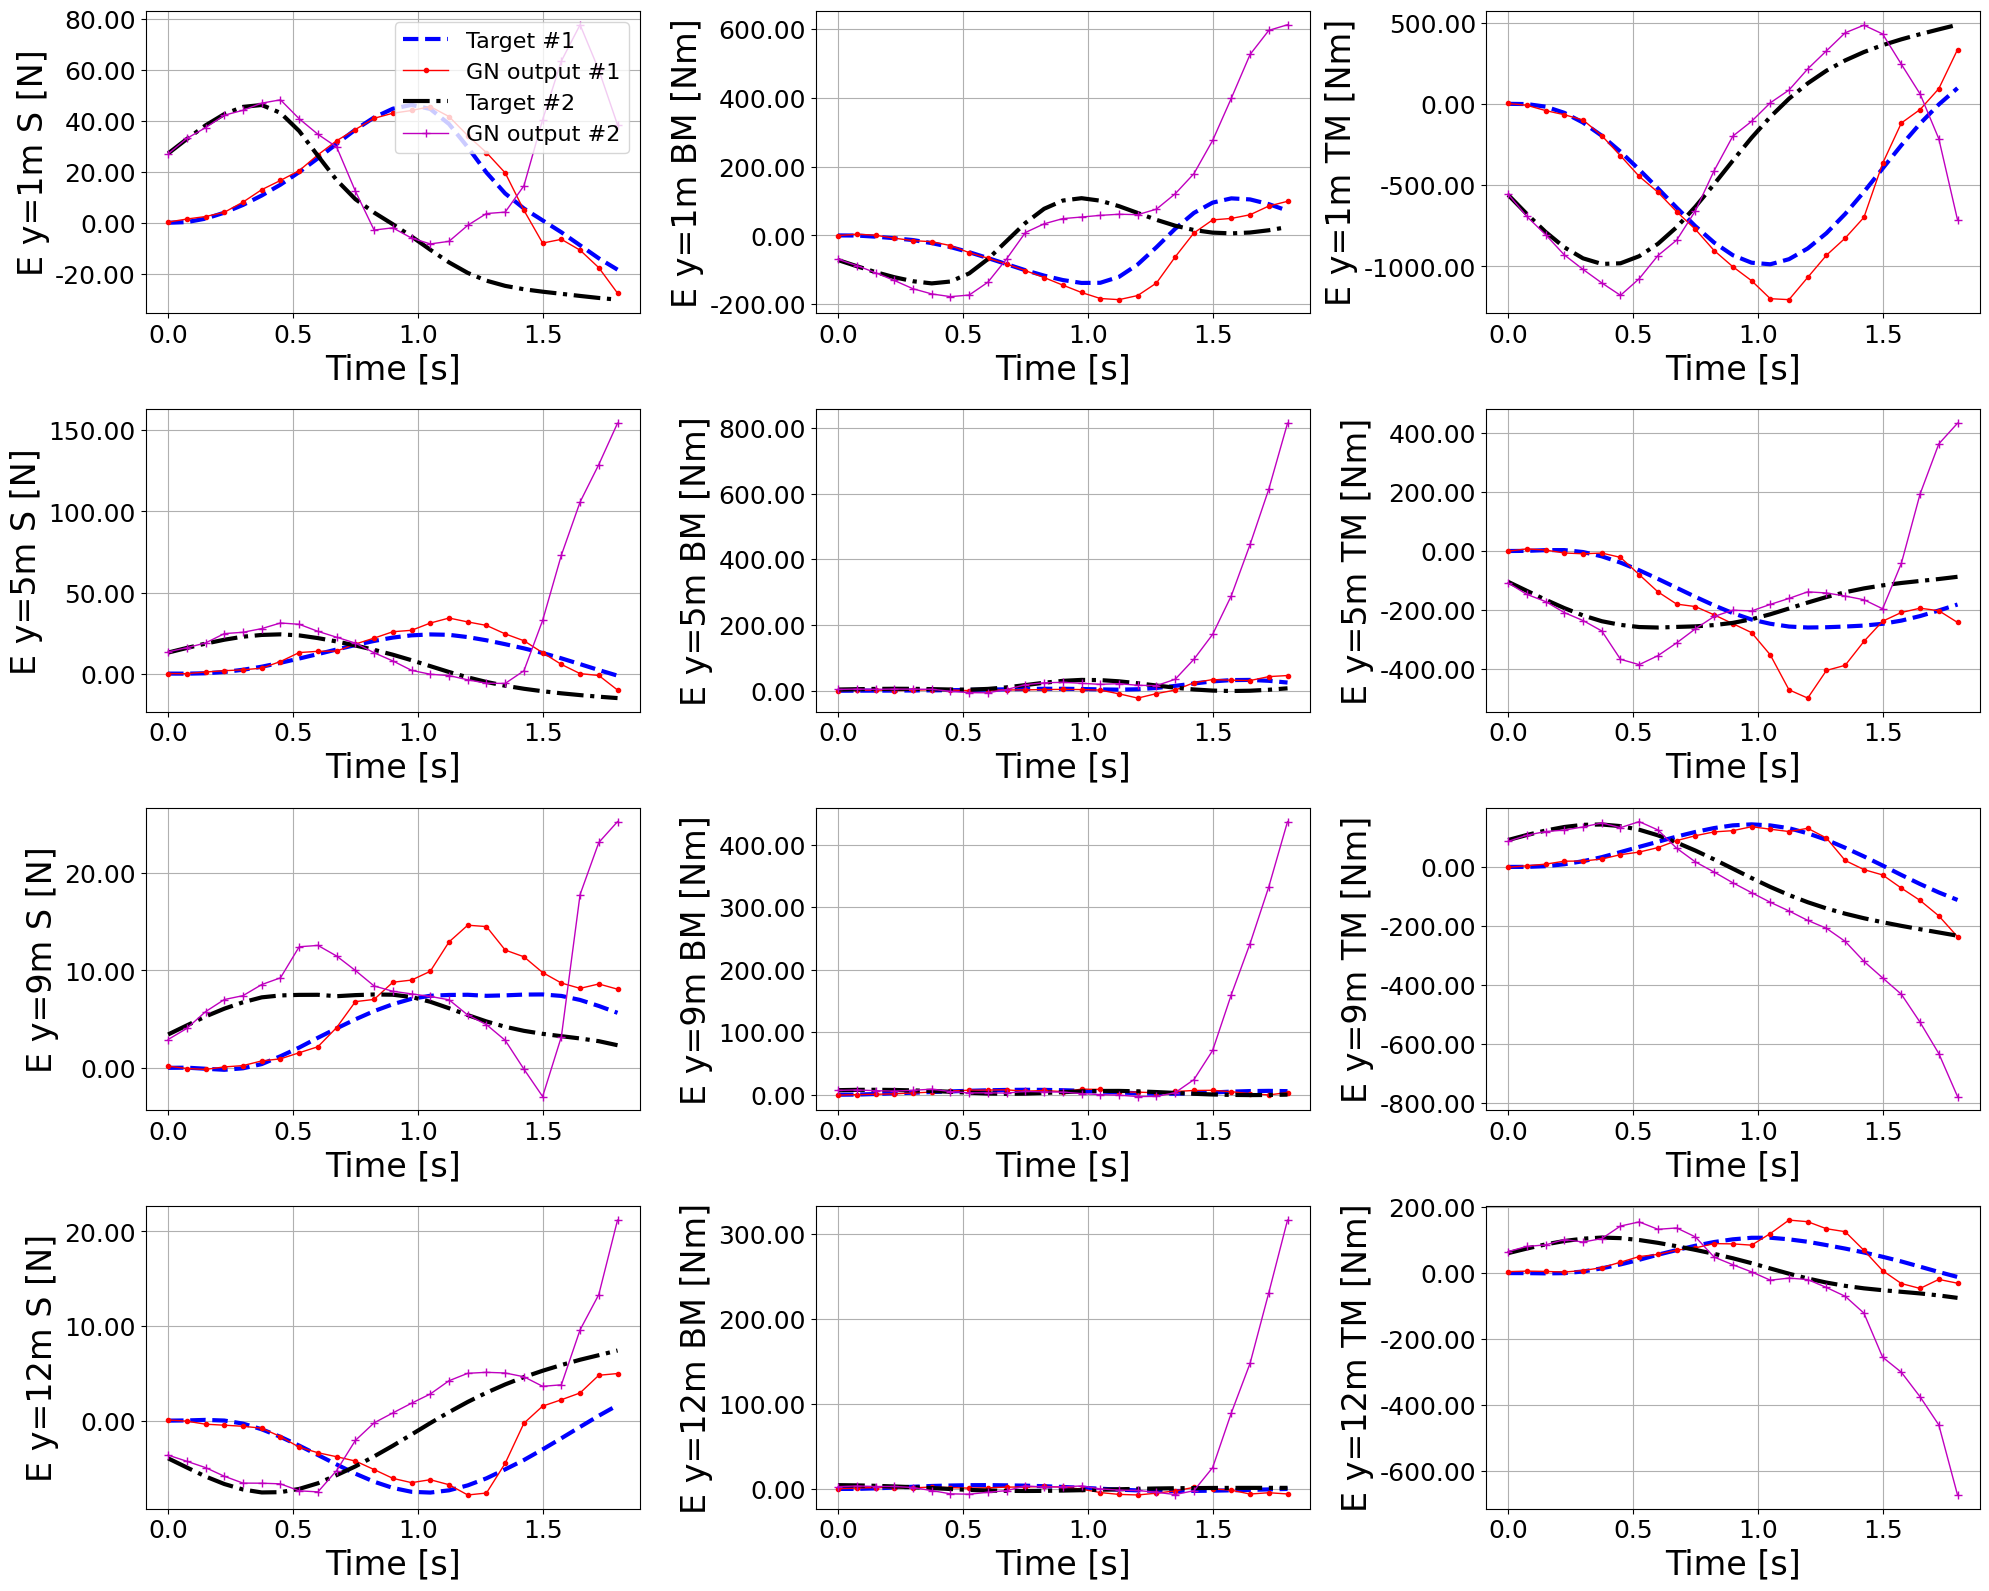

In [163]:
plot_object(idx_object=1,n_object=8,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out_valid',dtloc=dt) #loads valid


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


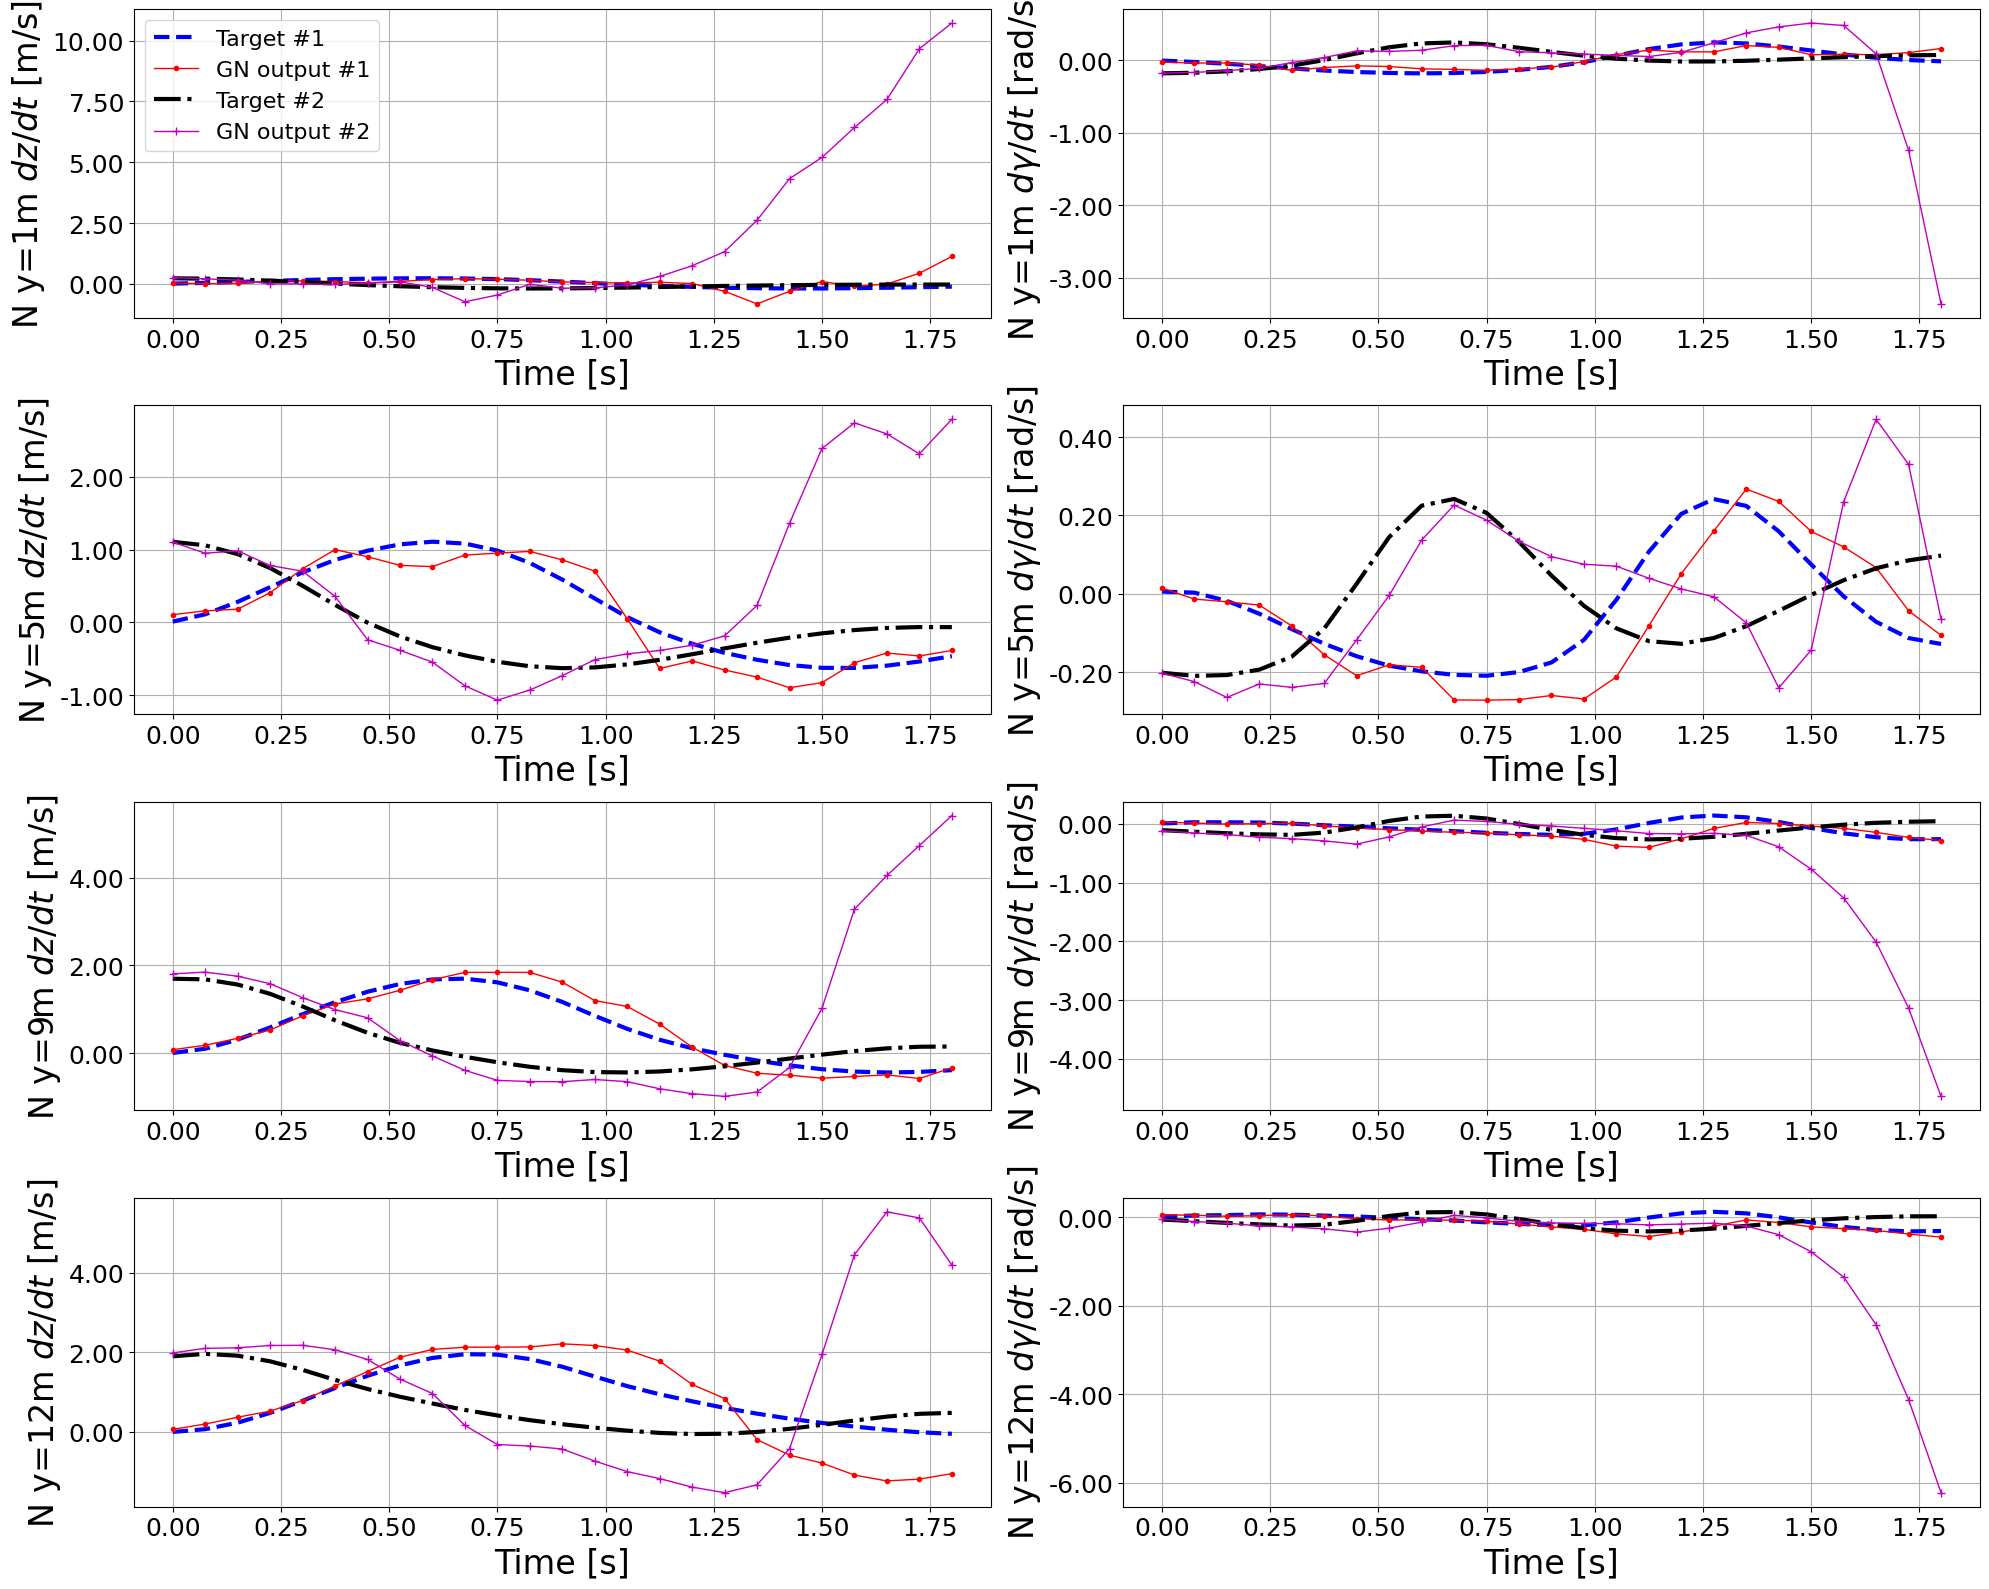

In [164]:
plot_object(idx_object=0,n_object=9,list_tss=list_tss,list_tse=list_tss+int(tlen/2),graph_target=tfgraphs_ro_tar,graph_out=tfgraphs_ro_out,filename_fig='Roll_out_valid',dtloc=dt) #loads valid
